## These models predict deltaI, deltaR, and the scale factor using training data created with the MATLAB code HexagonSpec_TrainingData_PS_sf. Before training these models, we take out the first peak information. 


In [1]:
#Load packages
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *

from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  



## This function will plot the true vs. predicted with various line fits
def plotSummary(true, predicted, name):
    #from pylab import *
    #import numpy as np
    #import matplotlib.pyplot as plt
    
    figure()
    plt.scatter(true,predicted, alpha = 0.2)
    
    plt.title(name)
    plt.xlabel('True')
    plt.ylabel('Predicted')

    xmin, xmax = plt.xlim()
    plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one

    fit_temp = np.polyfit(true, predicted,1)
    xp = np.linspace(xmin, xmax, 100)
    p = np.poly1d(fit_temp)
    plt.plot(xp, p(xp), '-', color = 'black')
    
    print(' ')
    print('RMSE on test data:', np.sqrt(mean_squared_error(true, predicted)), 'for ', name)
    print('R^2 Score on test data:', r2_score(true, predicted), 'for', name)

    
    return

def myResiduals(testY, predictY):
    ## residuals 1
    i = 0 # resetting i
    iterations = len(testY) # gets number of dots/points
    residual_sum = 0 # initializes sum of residuals
    for i in range (0,iterations): # for every dot/point
       ys = testY # get ys of testing data
       ys = ys.values # take out indexing, data types, names
       y = ys[i]
       predict_ys = predictY.values # get ys of all dots/points
       predict_y = predict_ys[i] # get the y value of the dot/point at specfic x value i
       diff = y - predict_y # find the difference in height
       diff = abs(diff) # take the absolute value
       residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals
    residual_average = residual_sum/iterations # find the average of the residuals
    print('The average residual for predict:', round(residual_average,4)) # display average of residuals

    minY = min(ys) # find the minimum y value for testing data
    maxY = max(ys) # find the max y value for testing data
    minpredict = min(predictY) # find the min y value for the prediction data
    maxpredict = max(predictY) # find the max y value for the prediction data
    #print('minY', minY, 'maxY', maxY)
    #print('minpredict', minpredict, 'maxpredict', maxpredict)
    rangeY = minY + maxY # find the range of the testing data
    rangepredict = minpredict - maxpredict # find the range of the predictions
    #print('rangeY', rangeY)
    #print('rangepredict', rangepredict)
    residual_percent_rangepredict = (residual_average/abs(rangepredict))*100 # calculate what percent the residual is of the range
    print('Residual is this percent of predict range', round(residual_percent_rangepredict,3), '%')
    
    return

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [2]:
# Creating Column Names 
peak_names = ['peak1', 'peak2', 'peak3', 'peak4']
locs_names = ['loc1', 'loc2', 'loc3', 'loc4']
width_names = ['width1', 'width2', 'width3','width4']
prom_names = ['prom1', 'prom2', 'prom3', 'prom4']

energy = (pd.read_csv('Training_Data/Hexagon/HexagonBias_v4.csv', header=None)*1000).round().astype(int)
energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]
# subset = 5 This would be used if we wanted a different number of spec points spaced differently. 
energy_names2 = energy_names[50:] # This would be used if we wanted to exclude the specs of the first peak -400 to -350 

col_names2 = ['deltaI', 'deltaR', 'scale factor']+ peak_names + locs_names + width_names + prom_names
col_names1 = ['deltaI', 'deltaR', 'scale factor'] + energy_names
# col_names_both = col_names2 + energy_names

# col_names1 = ['deltaI', 'deltaR'] + energy_names # this would be used if we didn't want the scale factor 
# col_names2 = ['deltaI', 'deltaR']+ peak_names + locs_names + width_names + prom_names # this one would be used if we didn't have the scale factor 
col_names_both = col_names2 + energy_names2 # this would be used if we wanted to exclude the first peak specs 


In [3]:
# Loading Training Data 
# Spec Points
data1 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData180721_PS_sf_specPoints.csv', header = None, names = col_names1)
# Peak Info 
data2 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData180721_PS_sf_peakinfo.csv', header = None, names = col_names2)


In [4]:
# Manipulating Training Data 
col_names1a = ['deltaI', 'deltaR', 'scale factor'] + energy_names2 # this would be used if we wanted to exclude the first peak 
data1 = data1[col_names1a] # this would be used if we wanted to exclude the first peak 

# Making combination data peak info + spec points  
data = data2.join(data1.drop(['deltaI', 'deltaR', 'scale factor'], axis = 1), how = 'left')
data = data[col_names_both]

X1 = data1.drop(['deltaI', 'deltaR', 'scale factor'], axis = 1)
Y1 = data1[['deltaI', 'deltaR', 'scale factor']]

X2 = data2.drop(['deltaI', 'deltaR', 'scale factor', 'peak1', 'prom1', 'loc1', 'width1'], axis = 1) # used if we don't want peak 1 info 
# X2 = data2.drop(['deltaI', 'deltaR', 'scale factor'], axis = 1)
Y2 = data2[['deltaI', 'deltaR', 'scale factor']]

X = data.drop(['deltaI', 'deltaR', 'scale factor',  'peak1', 'prom1', 'loc1', 'width1'], axis = 1) # used if we don't want peak 1 info 
# X = data.drop(['deltaI', 'deltaR', 'scale factor'], axis = 1)
Y = data[['deltaI', 'deltaR', 'scale factor']]

In [5]:
# Splitting Training and Testing Data 
ts1 = 0.3
rs1 = 42

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = ts1, random_state = rs1)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = ts1, random_state = rs1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = ts1, random_state = rs1)

In [6]:
# Checking Combination Data
data.head()

,deltaI,deltaR,scale factor,peak1,peak2,peak3,peak4,loc1,loc2,loc3,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.81472,-0.14798,0.92540,5.5270,3.6073,2.7934,2.0822,-0.330,-0.188,0.014,...,0.79315,0.79619,0.80108,0.80769,0.81622,0.82689,0.83950,0.85452,0.87135,0.89071
1,0.91338,-0.57749,0.91951,6.9182,4.4806,3.4147,2.4900,-0.330,-0.184,0.020,...,0.75409,0.74461,0.73631,0.73042,0.72601,0.72411,0.72401,0.72678,0.73174,0.73925
2,0.27850,-0.71176,1.09150,12.8630,8.3628,6.2103,4.2826,-0.362,-0.260,-0.112,...,0.94504,1.01710,1.08270,1.13740,1.17620,1.19690,1.20070,1.19350,1.18060,1.16850
3,0.96489,-1.32320,1.09410,8.2317,5.2311,3.9670,2.8809,-0.360,-0.256,-0.106,...,0.64950,0.68033,0.71423,0.75075,0.79013,0.83161,0.87454,0.91832,0.96108,1.00240
4,0.95717,-0.80837,1.06010,7.6456,4.8266,3.6784,2.6796,-0.356,-0.246,-0.088,...,0.56019,0.54733,0.53630,0.52718,0.51946,0.51360,0.50916,0.50641,0.50506,0.50536


In [7]:
# Checking Combination Data 
X.head()

,peak2,peak3,peak4,loc2,loc3,loc4,width2,width3,width4,prom2,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,3.6073,2.7934,2.0822,-0.188,0.014,0.264,0.027049,0.039017,0.047773,3.2289,...,0.79315,0.79619,0.80108,0.80769,0.81622,0.82689,0.83950,0.85452,0.87135,0.89071
1,4.4806,3.4147,2.4900,-0.184,0.020,0.272,0.022376,0.033262,0.041401,4.1692,...,0.75409,0.74461,0.73631,0.73042,0.72601,0.72411,0.72401,0.72678,0.73174,0.73925
2,8.3628,6.2103,4.2826,-0.260,-0.112,0.074,0.008818,0.014094,0.019757,8.1903,...,0.94504,1.01710,1.08270,1.13740,1.17620,1.19690,1.20070,1.19350,1.18060,1.16850
3,5.2311,3.9670,2.8809,-0.256,-0.106,0.084,0.014092,0.021635,0.029160,4.9645,...,0.64950,0.68033,0.71423,0.75075,0.79013,0.83161,0.87454,0.91832,0.96108,1.00240
4,4.8266,3.6784,2.6796,-0.246,-0.088,0.112,0.016079,0.024375,0.032524,4.5388,...,0.56019,0.54733,0.53630,0.52718,0.51946,0.51360,0.50916,0.50641,0.50506,0.50536


In [8]:
# Checking Spec points Data 
X1.head()

,E_-300_mV,E_-298_mV,E_-296_mV,E_-294_mV,E_-292_mV,E_-290_mV,E_-288_mV,E_-286_mV,E_-284_mV,E_-282_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.39734,0.36634,0.34080,0.31892,0.30075,0.28534,0.27227,0.26111,0.25170,0.24400,...,0.79315,0.79619,0.80108,0.80769,0.81622,0.82689,0.83950,0.85452,0.87135,0.89071
1,0.34614,0.31661,0.29207,0.27174,0.25472,0.24014,0.22803,0.21765,0.20885,0.20145,...,0.75409,0.74461,0.73631,0.73042,0.72601,0.72411,0.72401,0.72678,0.73174,0.73925
2,0.12241,0.13088,0.14091,0.15295,0.16775,0.18565,0.20761,0.23508,0.26938,0.31325,...,0.94504,1.01710,1.08270,1.13740,1.17620,1.19690,1.20070,1.19350,1.18060,1.16850
3,0.17912,0.18884,0.20004,0.21358,0.23003,0.24970,0.27337,0.30191,0.33636,0.37891,...,0.64950,0.68033,0.71423,0.75075,0.79013,0.83161,0.87454,0.91832,0.96108,1.00240
4,0.16985,0.17412,0.17971,0.18654,0.19483,0.20462,0.21630,0.23020,0.24679,0.26613,...,0.56019,0.54733,0.53630,0.52718,0.51946,0.51360,0.50916,0.50641,0.50506,0.50536


In [9]:
# Checking Spec Points Data 
data1.head()

,deltaI,deltaR,scale factor,E_-300_mV,E_-298_mV,E_-296_mV,E_-294_mV,E_-292_mV,E_-290_mV,E_-288_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.81472,-0.14798,0.92540,0.39734,0.36634,0.34080,0.31892,0.30075,0.28534,0.27227,...,0.79315,0.79619,0.80108,0.80769,0.81622,0.82689,0.83950,0.85452,0.87135,0.89071
1,0.91338,-0.57749,0.91951,0.34614,0.31661,0.29207,0.27174,0.25472,0.24014,0.22803,...,0.75409,0.74461,0.73631,0.73042,0.72601,0.72411,0.72401,0.72678,0.73174,0.73925
2,0.27850,-0.71176,1.09150,0.12241,0.13088,0.14091,0.15295,0.16775,0.18565,0.20761,...,0.94504,1.01710,1.08270,1.13740,1.17620,1.19690,1.20070,1.19350,1.18060,1.16850
3,0.96489,-1.32320,1.09410,0.17912,0.18884,0.20004,0.21358,0.23003,0.24970,0.27337,...,0.64950,0.68033,0.71423,0.75075,0.79013,0.83161,0.87454,0.91832,0.96108,1.00240
4,0.95717,-0.80837,1.06010,0.16985,0.17412,0.17971,0.18654,0.19483,0.20462,0.21630,...,0.56019,0.54733,0.53630,0.52718,0.51946,0.51360,0.50916,0.50641,0.50506,0.50536


In [10]:
# Checking Peak Info Data 
X2.head()

,peak2,peak3,peak4,loc2,loc3,loc4,width2,width3,width4,prom2,prom3,prom4
0,3.6073,2.7934,2.0822,-0.188,0.014,0.264,0.027049,0.039017,0.047773,3.2289,2.2541,1.3708
1,4.4806,3.4147,2.4900,-0.184,0.020,0.272,0.022376,0.033262,0.041401,4.1692,2.9615,1.8492
2,8.3628,6.2103,4.2826,-0.260,-0.112,0.074,0.008818,0.014094,0.019757,8.1903,5.9527,3.9421
3,5.2311,3.9670,2.8809,-0.256,-0.106,0.084,0.014092,0.021635,0.029160,4.9645,3.5713,2.4095
4,4.8266,3.6784,2.6796,-0.246,-0.088,0.112,0.016079,0.024375,0.032524,4.5388,3.2560,2.1745


In [11]:
# Checking Peak Info Data 
data2.head()

,deltaI,deltaR,scale factor,peak1,peak2,peak3,peak4,loc1,loc2,loc3,loc4,width1,width2,width3,width4,prom1,prom2,prom3,prom4
0,0.81472,-0.14798,0.92540,5.5270,3.6073,2.7934,2.0822,-0.330,-0.188,0.014,0.264,0.013442,0.027049,0.039017,0.047773,5.3064,3.2289,2.2541,1.3708
1,0.91338,-0.57749,0.91951,6.9182,4.4806,3.4147,2.4900,-0.330,-0.184,0.020,0.272,0.010976,0.022376,0.033262,0.041401,6.7412,4.1692,2.9615,1.8492
2,0.27850,-0.71176,1.09150,12.8630,8.3628,6.2103,4.2826,-0.362,-0.260,-0.112,0.074,0.004383,0.008818,0.014094,0.019757,12.7690,8.1903,5.9527,3.9421
3,0.96489,-1.32320,1.09410,8.2317,5.2311,3.9670,2.8809,-0.360,-0.256,-0.106,0.084,0.006798,0.014092,0.021635,0.029160,8.0815,4.9645,3.5713,2.4095
4,0.95717,-0.80837,1.06010,7.6456,4.8266,3.6784,2.6796,-0.356,-0.246,-0.088,0.112,0.007563,0.016079,0.024375,0.032524,7.4829,4.5388,3.2560,2.1745


# Using the Best Models on the Hexagon Data 

## Decision Tree

### spec points

 
RMSE on test data: 0.13261098491360895 for  deltaI Depth 60
R^2 Score on test data: 0.7846390662815935 for deltaI Depth 60
 
RMSE on test data: 0.20540222193074054 for  deltaR Depth 60
R^2 Score on test data: 0.7960129159849854 for deltaR Depth 60
 
RMSE on test data: 0.016186661851555584 for  scale factor Depth 60
R^2 Score on test data: 0.9215732955330809 for scale factor Depth 60


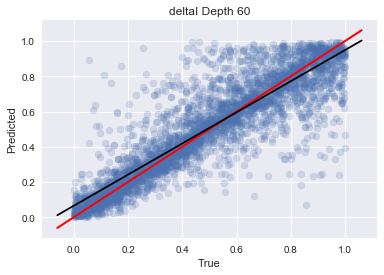

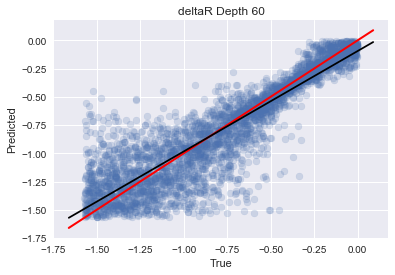

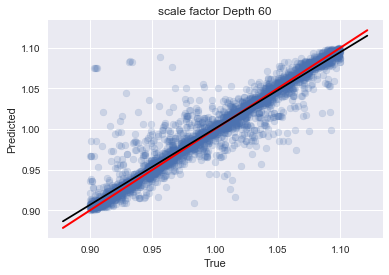

In [12]:
#Initialize the model
rs = 42
regr_DT_sp = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
regr_DT_sp = regr_DT_sp.fit(X1_train, Y1_train)

#print(data1[data1['Regr - DT']>0.001]) # feature importances 

#Use model to predict
predictions_DT_sp = regr_DT_sp.predict(X1_test)

#Plot results
plotSummary(Y1_test['deltaI'], predictions_DT_sp[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y1_test['deltaR'], predictions_DT_sp[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])
plotSummary(Y1_test['scale factor'], predictions_DT_sp[:,2], 'scale factor Depth 60')
#myResiduals(Y_test['scale factor'], y_3[:,2])

In [13]:
# spec info decision tree feature importances 
FI_sp_DT = pd.DataFrame(regr_DT_sp.feature_importances_.T, columns = ['Spec - DT'])
FI_sp_DT.index = X1_train.columns

#print(FI_sp_DT[FI_sp_DT['Spec - DT']>0.001])
features_sp_DT = (FI_sp_DT[FI_sp_DT['Spec - DT']>0.006])
features_sp_DT_sorted = features_sp_DT.sort_values('Spec - DT', ascending = False)

### peak info

 
RMSE on test data: 0.06361556894808455 for  deltaI Depth 60
R^2 Score on test data: 0.9504396054002201 for deltaI Depth 60
 
RMSE on test data: 0.12893756158854966 for  deltaR Depth 60
R^2 Score on test data: 0.9196193894212624 for deltaR Depth 60
 
RMSE on test data: 0.028251643031920928 for  scale factor Depth 60
R^2 Score on test data: 0.7610886413116869 for scale factor Depth 60


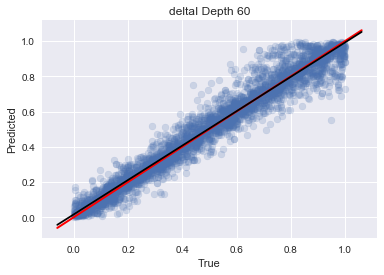

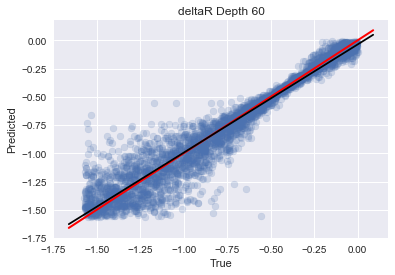

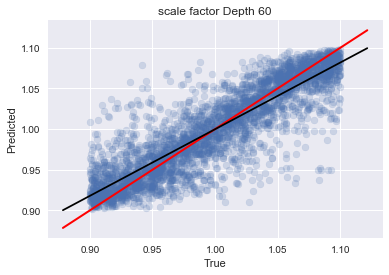

In [14]:
#Initialize the model
rs = 42
regr_DT_pi = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
regr_DT_pi.fit(X2_train, Y2_train)


#print(data1[data1['Regr - DT']>0.001])

#Use model to predict
predictions_DT_pi = regr_DT_pi.predict(X2_test)

#Plot results
plotSummary(Y2_test['deltaI'], predictions_DT_pi[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y2_test['deltaR'], predictions_DT_pi[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])
plotSummary(Y2_test['scale factor'], predictions_DT_pi[:,2], 'scale factor Depth 60')
#myResiduals(Y_test['scale factor'], y_3[:,2])

In [15]:
# peak info decision tree feature importances 
FI_pi_DT = pd.DataFrame(regr_DT_pi.feature_importances_.T, columns = ['Peak - DT'])
FI_pi_DT.index = X2_train.columns

#print(FI_pi_DT[FI_sp_DT['Peak - DT']>0.001])
features_pi_DT = (FI_pi_DT[FI_pi_DT['Peak - DT']>0.006])
features_pi_DT_sorted = features_pi_DT.sort_values('Peak - DT', ascending = False)

### spec points and peak info

 
RMSE on test data: 0.08151418851169612 for  deltaI Depth 60
R^2 Score on test data: 0.9186281212859663 for deltaI Depth 60
 
RMSE on test data: 0.14937941132278254 for  deltaR Depth 60
R^2 Score on test data: 0.8921118161154161 for deltaR Depth 60
 
RMSE on test data: 0.03252085663889833 for  scale factor Depth 60
R^2 Score on test data: 0.6834273937762787 for scale factor Depth 60


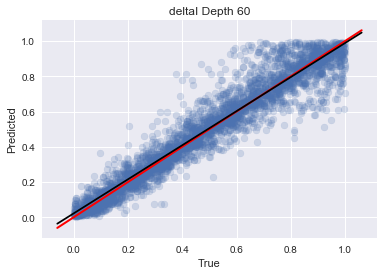

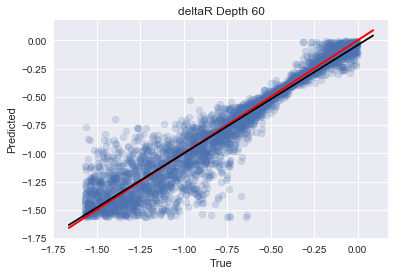

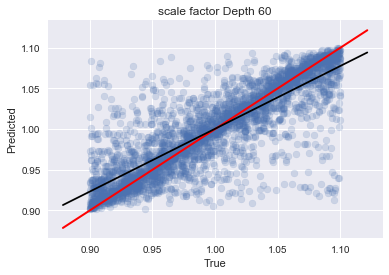

In [16]:
#Initialize the model
rs = 42
regr_DT_both = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
regr_DT_both.fit(X_train, Y_train)


#print(data1[data1['Regr - DT']>0.001])

#Use model to predict
predictions_DT_both = regr_DT_both.predict(X_test)

#Plot results
plotSummary(Y_test['deltaI'], predictions_DT_both[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y_test['deltaR'], predictions_DT_both[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])
plotSummary(Y_test['scale factor'], predictions_DT_both[:,2], 'scale factor Depth 60')
#myResiduals(Y_test['scale factor'], y_3[:,2])

In [17]:
# combined info decision tree feature importances 
FI_b_DT = pd.DataFrame(regr_DT_both.feature_importances_.T, columns = ['Both - DT'])
FI_b_DT.index = X_train.columns

#print(FI_b_DT[FI_b_DT['Both - DT']>0.001])
features_b_DT = (FI_b_DT[FI_b_DT['Both - DT']>0.006])
features_b_DT_sorted = features_b_DT.sort_values('Both - DT', ascending = False)

In [18]:
display_side_by_side(features_sp_DT_sorted, features_b_DT_sorted, features_pi_DT_sorted,)

,Spec - DT
E_-290_mV,0.444759
E_-216_mV,0.107755
E_-288_mV,0.035395
E_-292_mV,0.035205
E_-296_mV,0.019299
E_-38_mV,0.016992
E_-300_mV,0.010089
E_-36_mV,0.009763
E_72_mV,0.009490
,Both - DT


## Random Forest

### spec points

 
RMSE on test data: 0.09400746308853998 for  deltaI RF spec
R^2 Score on test data: 0.8917737551371799 for deltaI RF spec
 
RMSE on test data: 0.14930891225784199 for  deltaR RF spec
R^2 Score on test data: 0.8922136269499745 for deltaR RF spec
 
RMSE on test data: 0.006880140025247586 for  scale factor RF spec
R^2 Score on test data: 0.9858308456243713 for scale factor RF spec


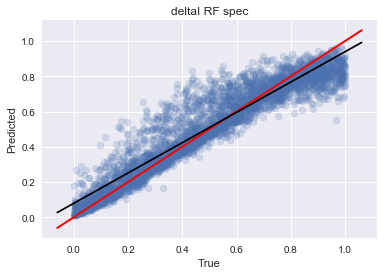

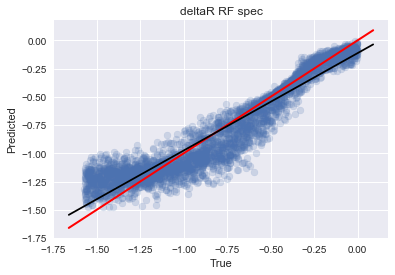

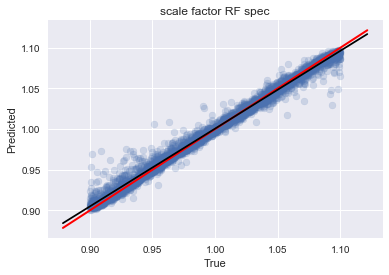

In [19]:
rs = 42
regr_RF_sp = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF_sp = regr_RF_sp.fit(X1_train, Y1_train)

predictions_RF_sp = model_RF_sp.predict(X1_test)

plotSummary(Y1_test['deltaI'], predictions_RF_sp[:,0], 'deltaI RF spec')
plotSummary(Y1_test['deltaR'], predictions_RF_sp[:,1], 'deltaR RF spec')
plotSummary(Y1_test['scale factor'], predictions_RF_sp[:,2], 'scale factor RF spec')

In [20]:
# spec info random forest feature importances 
FI_sp_RF = pd.DataFrame(regr_RF_sp.feature_importances_.T, columns = ['Spec - RF'])
FI_sp_RF.index = X1_train.columns

#print(FI_sp_RF[FI_sp_RF['Spec - RF']>0.001])
features_sp_RF = (FI_sp_RF[FI_sp_RF['Spec - RF']>0.006])
features_sp_RF_sorted = features_sp_RF.sort_values('Spec - RF', ascending = False)

### peak info

 
RMSE on test data: 0.04552950561700394 for  deltaI RF PI
R^2 Score on test data: 0.9746140281972633 for deltaI RF PI
 
RMSE on test data: 0.09559191148205083 for  deltaR RF PI
R^2 Score on test data: 0.9558190869107942 for deltaR RF PI
 
RMSE on test data: 0.013011869980768982 for  scale factor RF PI
R^2 Score on test data: 0.9493209100272825 for scale factor RF PI


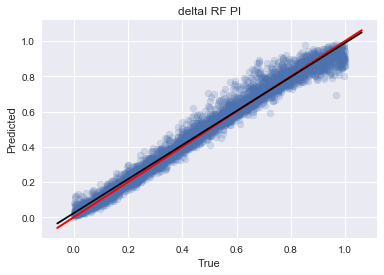

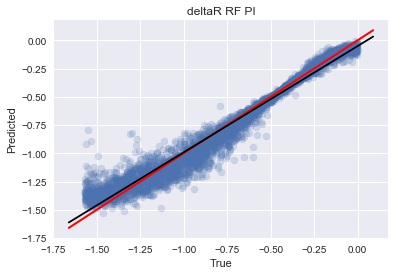

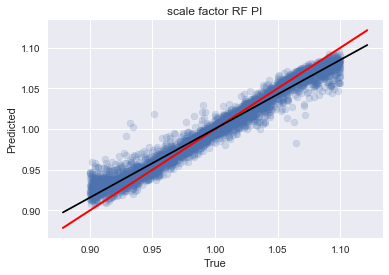

In [21]:
rs = 42
regr_RF_pi = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF_pi = regr_RF_pi.fit(X2_train, Y2_train)

predictions_RF_pi = model_RF_pi.predict(X2_test)

plotSummary(Y2_test['deltaI'], predictions_RF_pi[:,0], 'deltaI RF PI')
plotSummary(Y2_test['deltaR'], predictions_RF_pi[:,1], 'deltaR RF PI')
plotSummary(Y2_test['scale factor'], predictions_RF_pi[:,2], 'scale factor RF PI')

In [22]:
# peak info random forest feature importances 
FI_pi_RF = pd.DataFrame(regr_RF_pi.feature_importances_.T, columns = ['Peak - RF'])
FI_pi_RF.index = X2_train.columns

#print(FI_pi_RF[FI_sp_RF['Peak - RF']>0.001])
features_pi_RF = (FI_pi_RF[FI_pi_RF['Peak - RF']>0.006])
features_pi_RF_sorted = features_pi_RF.sort_values('Peak - RF', ascending = False)

### spec points and peak info

 
RMSE on test data: 0.05598583032010966 for  deltaI RF Combo
R^2 Score on test data: 0.9616147678617688 for deltaI RF Combo
 
RMSE on test data: 0.11217466080424512 for  deltaR RF Combo
R^2 Score on test data: 0.9391610198606394 for deltaR RF Combo
 
RMSE on test data: 0.013829250036616125 for  scale factor RF Combo
R^2 Score on test data: 0.9427538036927398 for scale factor RF Combo


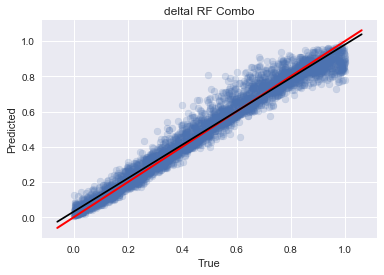

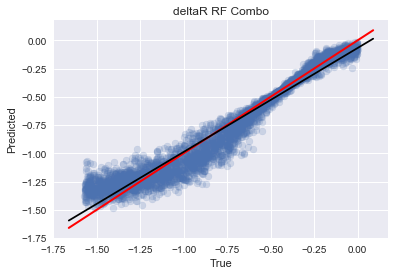

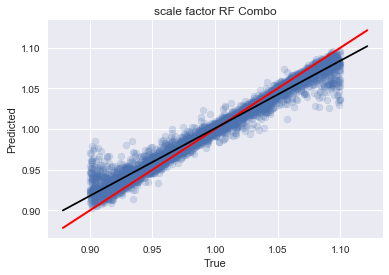

In [23]:
rs = 42
regr_RF_both = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF_both = regr_RF_both.fit(X_train, Y_train)

predictions_RF_both = model_RF_both.predict(X_test)

plotSummary(Y_test['deltaI'], predictions_RF_both[:,0], 'deltaI RF Combo')
plotSummary(Y_test['deltaR'], predictions_RF_both[:,1], 'deltaR RF Combo')
plotSummary(Y_test['scale factor'], predictions_RF_both[:,2], 'scale factor RF Combo')

In [24]:
# combined info decision tree feature importances 
FI_b_RF = pd.DataFrame(regr_RF_both.feature_importances_.T, columns = ['Both - RF'])
FI_b_RF.index = X_train.columns

#print(FI_b_RF[FI_b_RF['Both - RF']>0.001])
features_b_RF = (FI_b_RF[FI_b_RF['Both - RF']>0.006])
features_b_RF_sorted = features_b_RF.sort_values('Both - RF', ascending = False)

In [25]:
display_side_by_side(features_pi_RF_sorted, features_sp_RF_sorted, features_b_RF_sorted)

,Peak - RF
peak4,0.622156
peak2,0.192364
prom4,0.053880
width2,0.033183
prom2,0.027499
prom3,0.024502
peak3,0.016394
width3,0.009465
width4,0.009376
,Spec - RF


## Independent Random Forests

### spec points


Score - Random Forest: 0.9014356613290585 for deltaR IRF
 
RMSE on test data: 0.1427787937365427 for  deltaR 10
R^2 Score on test data: 0.9014356613290586 for deltaR 10
 
RMSE on test data: 0.08467967303746686 for  deltaI 10
R^2 Score on test data: 0.9121854926594234 for deltaI 10
 
RMSE on test data: 0.005043831690157201 for  scale factor IRF
R^2 Score on test data: 0.9923849887417359 for scale factor IRF


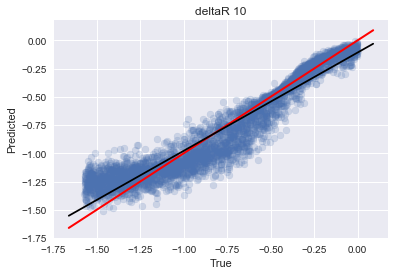

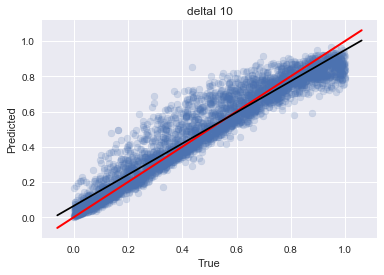

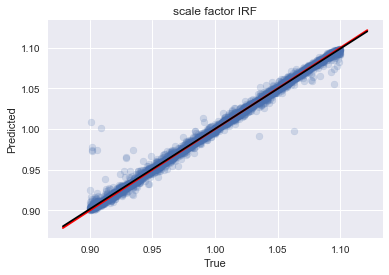

In [26]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

regr_RF2_dr_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_di_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_sf_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

model_RF2_dr_sp = regr_RF2_dr_sp.fit(X1_train, Y1_train['deltaR'])
model_RF2_di_sp = regr_RF2_di_sp.fit(X1_train, Y1_train['deltaI'])
model_RF2_sf_sp = regr_RF2_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_RF2_dr_sp = model_RF2_dr_sp.predict(X1_test)
predictions_RF2_di_sp = model_RF2_di_sp.predict(X1_test)
predictions_RF2_sf_sp = model_RF2_sf_sp.predict(X1_test)

#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF2_dr_sp.score(X1_test, Y1_test['deltaR']), 'for deltaR IRF')

plotSummary(Y1_test['deltaR'], predictions_RF2_dr_sp, 'deltaR 10')
plotSummary(Y1_test['deltaI'], predictions_RF2_di_sp, 'deltaI 10')
plotSummary(Y1_test['scale factor'], predictions_RF2_sf_sp, 'scale factor IRF')

In [27]:
# spec info independent random forest feature importances delta R  
FI_sp_RF2_dr = pd.DataFrame(model_RF2_dr_sp.feature_importances_.T, columns = ['Spec - RF2_dr'])
FI_sp_RF2_dr.index = X1_train.columns

# print(FI_sp_RF2_dr[FI_sp_RF2_dr['Spec - RF2_dr']>0.001])
features_sp_RF2_dr = (FI_sp_RF2_dr[FI_sp_RF2_dr['Spec - RF2_dr']>0.006])
features_sp_RF2_dr_sorted = features_sp_RF2_dr.sort_values('Spec - RF2_dr', ascending = False)

# spec info independent random forest feature importances delta I  
FI_sp_RF2_di = pd.DataFrame(model_RF2_di_sp.feature_importances_.T, columns = ['Spec - RF2_di'])
FI_sp_RF2_di.index = X1_train.columns

# print(FI_sp_RF2_di[FI_sp_RF2_di['Spec - RF2_di']>0.001])
features_sp_RF2_di = (FI_sp_RF2_di[FI_sp_RF2_di['Spec - RF2_di']>0.006])
features_sp_RF2_di_sorted = features_sp_RF2_di.sort_values('Spec - RF2_di', ascending = False)

# spec info independent random forest feature importances scale factor 
FI_sp_RF2_sf = pd.DataFrame(model_RF2_sf_sp.feature_importances_.T, columns = ['Spec - RF2_sf'])
FI_sp_RF2_sf.index = X1_train.columns

# print(FI_sp_RF2_sf[FI_sp_RF2_sf['Spec - RF2_sf']>0.001])
features_sp_RF2_sf = (FI_sp_RF2_sf[FI_sp_RF2_sf['Spec - RF2_sf']>0.006])
features_sp_RF2_sf_sorted = features_sp_RF2_sf.sort_values('Spec - RF2_sf', ascending = False)

### peak info


Score - Random Forest: 0.956469512979761 for delta R IRF PI
 
RMSE on test data: 0.09488565620242177 for  deltaI IRF PI
R^2 Score on test data: 0.9564695129797609 for deltaI IRF PI
 
RMSE on test data: 0.04353614662166321 for  deltaR IRF PI
R^2 Score on test data: 0.9767882492527209 for deltaR IRF PI
 
RMSE on test data: 0.006766515539352622 for  scale factor IRF PI
R^2 Score on test data: 0.986294984065525 for scale factor IRF PI


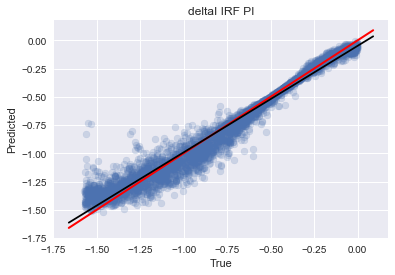

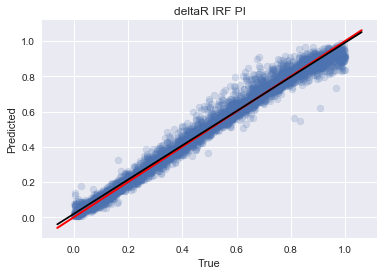

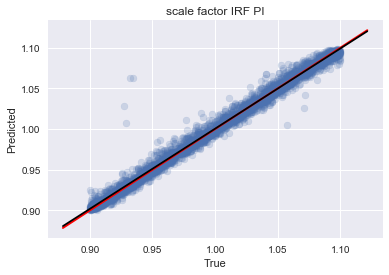

In [28]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

regr_RF2_dr_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_di_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_sf_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

model_RF2_dr_pi = regr_RF2_dr_pi.fit(X2_train, Y2_train['deltaR'])
model_RF2_di_pi = regr_RF2_di_pi.fit(X2_train, Y2_train['deltaI'])
model_RF2_sf_pi = regr_RF2_sf_pi.fit(X2_train, Y2_train['scale factor'])

predictions_RF2_dr_pi = model_RF2_dr_pi.predict(X2_test)
predictions_RF2_di_pi = model_RF2_di_pi.predict(X2_test)
predictions_RF2_sf_pi = model_RF2_sf_pi.predict(X2_test)


#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF2_dr_pi.score(X2_test, Y2_test['deltaR']), 'for delta R IRF PI')

plotSummary(Y2_test['deltaR'], predictions_RF2_dr_pi, 'deltaI IRF PI')
plotSummary(Y2_test['deltaI'], predictions_RF2_di_pi, 'deltaR IRF PI')
plotSummary(Y2_test['scale factor'], predictions_RF2_sf_pi, 'scale factor IRF PI')

In [29]:
# peak info independent random forest feature importances delta R  
FI_pi_RF2_dr = pd.DataFrame(model_RF2_dr_pi.feature_importances_.T, columns = ['Peak - RF2_dr'])
FI_pi_RF2_dr.index = X2_train.columns

# print(FI_pi_RF2_dr[FI_pi_RF2_dr['Peak - RF2_dr']>0.001])
features_pi_RF2_dr = (FI_pi_RF2_dr[FI_pi_RF2_dr['Peak - RF2_dr']>0.006])
features_pi_RF2_dr_sorted = features_pi_RF2_dr.sort_values('Peak - RF2_dr', ascending = False)


# peak info independent random forest feature importances delta I 
FI_pi_RF2_di = pd.DataFrame(model_RF2_di_pi.feature_importances_.T, columns = ['Peak - RF2_di'])
FI_pi_RF2_di.index = X2_train.columns

# print(FI_pi_RF2_di[FI_pi_RF2_di['Peak - RF2_di']>0.001])
features_pi_RF2_di = (FI_pi_RF2_di[FI_pi_RF2_di['Peak - RF2_di']>0.006])
features_pi_RF2_di_sorted = features_pi_RF2_di.sort_values('Peak - RF2_di', ascending = False)

# peak info independent random forest feature importances scale factor
FI_pi_RF2_sf = pd.DataFrame(model_RF2_sf_pi.feature_importances_.T, columns = ['Peak - RF2_sf'])
FI_pi_RF2_sf.index = X2_train.columns

# print(FI_pi_RF2_sf[FI_pi_RF2_sf['Peak - RF2_sf']>0.001])
features_pi_RF2_sf = (FI_pi_RF2_sf[FI_pi_RF2_sf['Peak - RF2_sf']>0.006])
features_pi_RF2_sf_sorted = features_pi_RF2_sf.sort_values('Peak - RF2_sf', ascending = False)


### spec points and peak info


Score - Random Forest: 0.9191986662057372 for delta R IRF Both
 
RMSE on test data: 0.12927455969159102 for  deltaI 10
R^2 Score on test data: 0.9191986662057372 for deltaI 10
 
RMSE on test data: 0.05979434588440414 for  deltaR 10
R^2 Score on test data: 0.9562147168154932 for deltaR 10
 
RMSE on test data: 0.00500261890824986 for  deltaR IRF Both
R^2 Score on test data: 0.9925089237390426 for deltaR IRF Both


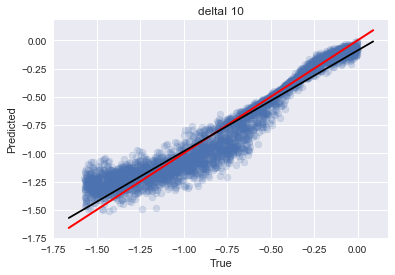

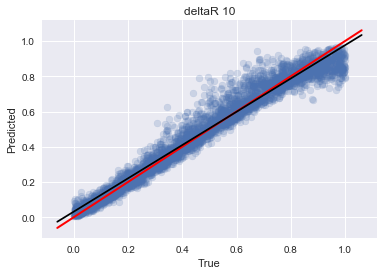

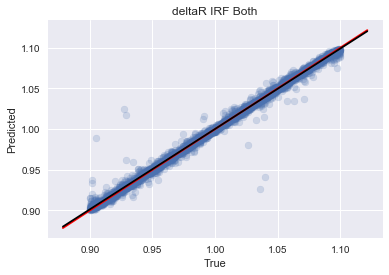

In [30]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

regr_RF2_dr_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_di_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_sf_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

model_RF2_dr_both = regr_RF2_dr_both.fit(X_train, Y_train['deltaR'])
model_RF2_di_both = regr_RF2_di_both.fit(X_train, Y_train['deltaI'])
model_RF2_sf_both = regr_RF2_sf_both.fit(X_train, Y_train['scale factor'])

predictions_RF2_dr_both = model_RF2_dr_both.predict(X_test)
predictions_RF2_di_both = model_RF2_di_both.predict(X_test)
predictions_RF2_sf_both = model_RF2_sf_both.predict(X_test)

#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF2_dr_both.score(X_test, Y_test['deltaR']), 'for delta R IRF Both')

plotSummary(Y_test['deltaR'], predictions_RF2_dr_both, 'deltaI 10')
plotSummary(Y_test['deltaI'], predictions_RF2_di_both, 'deltaR 10')
plotSummary(Y_test['scale factor'], predictions_RF2_sf_both, 'deltaR IRF Both')

In [31]:
# combined info independent random forest feature importances delta R  
FI_b_RF2_dr = pd.DataFrame(model_RF2_dr_both.feature_importances_.T, columns = ['Both - RF2_dr'])
FI_b_RF2_dr.index = X_train.columns

# print(FI_b_RF2_dr[FI_b_RF2_dr['Both - RF2_dr']>0.001])
features_b_RF2_dr = (FI_b_RF2_dr[FI_b_RF2_dr['Both - RF2_dr']>0.006])
features_b_RF2_dr_sorted = features_b_RF2_dr.sort_values('Both - RF2_dr', ascending = False)


# combined info independent random forest feature importances delta I  
FI_b_RF2_di = pd.DataFrame(model_RF2_di_both.feature_importances_.T, columns = ['Both - RF2_di'])
FI_b_RF2_di.index = X_train.columns

# print(FI_b_RF2_di[FI_b_RF2_di['Both - RF2_di']>0.001])
features_b_RF2_di = (FI_b_RF2_di[FI_b_RF2_di['Both - RF2_di']>0.006])
features_b_RF2_di_sorted = features_b_RF2_di.sort_values('Both - RF2_di', ascending = False)

# combined info independent random forest feature importances scale factor 
FI_b_RF2_sf = pd.DataFrame(model_RF2_sf_both.feature_importances_.T, columns = ['Both - RF2_sf'])
FI_b_RF2_sf.index = X_train.columns

# print(FI_b_RF2_sf[FI_b_RF2_sf['Both - RF2_sf']>0.001])
features_b_RF2_sf = (FI_b_RF2_sf[FI_b_RF2_sf['Both - RF2_sf']>0.006])
features_b_RF2_sf_sorted = features_b_RF2_sf.sort_values('Both - RF2_sf', ascending = False)

In [32]:

display_side_by_side(features_sp_RF2_dr_sorted, features_sp_RF2_di_sorted, features_sp_RF2_sf_sorted, features_b_RF2_dr_sorted, features_b_RF2_di_sorted, features_b_RF2_sf_sorted)
display_side_by_side(features_pi_RF2_dr_sorted, features_pi_RF2_di_sorted, features_pi_RF2_sf_sorted)

,Spec - RF2_dr
E_-292_mV,0.344235
E_-290_mV,0.115348
E_-218_mV,0.052449
E_-216_mV,0.038162
E_-288_mV,0.032946
E_-36_mV,0.025254
E_-300_mV,0.014267
E_-34_mV,0.013396
E_-286_mV,0.013289
E_-38_mV,0.009894


,Peak - RF2_dr
peak4,0.721980
prom3,0.067700
peak2,0.048302
prom4,0.046636
peak3,0.027040
width2,0.024935
prom2,0.020257
width4,0.014789
loc2,0.013235
width3,0.009961


## AdaBoost Random Forest

### spec points

 
RMSE on test data: 0.08445151125757952 for  AdaBoost Delta I SP
R^2 Score on test data: 0.9126580717587635 for AdaBoost Delta I SP
 
RMSE on test data: 0.1418096162128374 for  AdaBoost Delta R SP
R^2 Score on test data: 0.9027692224893996 for AdaBoost Delta R SP
 
RMSE on test data: 0.00454496279831618 for  AdaBoost Scale Factor SP
R^2 Score on test data: 0.9938168462851303 for AdaBoost Scale Factor SP
Delta I AdaBoost Score: 0.9126580717587633
Delta R AdaBoost Score: 0.9027692224893997
Scale Factor AdaBoost Score: 0.9938168462851303


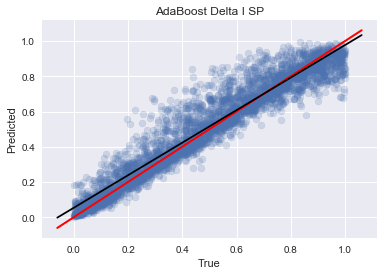

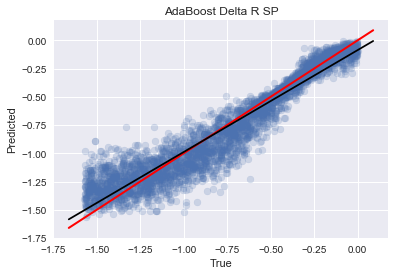

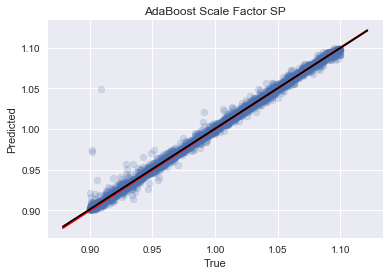

In [33]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB_di_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_AB_dr_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
regr_AB_sf_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

model_AB_di_sp = regr_AB_di_sp.fit(X1_train, Y1_train['deltaI'])
model_AB_dr_sp = regr_AB_dr_sp.fit(X1_train, Y1_train['deltaR'])
model_AB_sf_sp = regr_AB_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_AB_di_sp = model_AB_di_sp.predict(X1_test)
predictions_AB_dr_sp = model_AB_dr_sp.predict(X1_test)
predictions_AB_sf_sp = model_AB_sf_sp.predict(X1_test)


plotSummary(Y1_test['deltaI'], predictions_AB_di_sp, 'AdaBoost Delta I SP')
plotSummary(Y1_test['deltaR'], predictions_AB_dr_sp, 'AdaBoost Delta R SP')
plotSummary(Y1_test['scale factor'], predictions_AB_sf_sp, 'AdaBoost Scale Factor SP')

print('Delta I AdaBoost Score:', model_AB_di_sp.score(X1_test, Y1_test['deltaI']))
print('Delta R AdaBoost Score:', model_AB_dr_sp.score(X1_test, Y1_test['deltaR']))
print('Scale Factor AdaBoost Score:', model_AB_sf_sp.score(X1_test, Y1_test['scale factor']))


In [34]:
# spec info adaboost random forest feature importances delta R  
FI_sp_AB_dr = pd.DataFrame(model_AB_dr_sp.feature_importances_.T, columns = ['Spec - AB_dr'])
FI_sp_AB_dr.index = X1_train.columns

# print(FI_sp_AB_dr[FI_sp_AB_dr['Spec - AB_dr']>0.001])
features_sp_AB_dr = (FI_sp_AB_dr[FI_sp_AB_dr['Spec - AB_dr']>0.006])
features_sp_AB_dr_sorted = features_sp_AB_dr.sort_values('Spec - AB_dr', ascending = False)

# spec info adaboost random forest feature importances delta I  
FI_sp_AB_di = pd.DataFrame(model_AB_di_sp.feature_importances_.T, columns = ['Spec - AB_di'])
FI_sp_AB_di.index = X1_train.columns

# print(FI_sp_AB_di[FI_sp_AB_di['Spec - AB_di']>0.001])
features_sp_AB_di = (FI_sp_AB_di[FI_sp_AB_di['Spec - AB_di']>0.006])
features_sp_AB_di_sorted = features_sp_AB_di.sort_values('Spec - AB_di', ascending = False)

# spec info adaboost random forest feature importances scale factor 
FI_sp_AB_sf = pd.DataFrame(model_AB_sf_sp.feature_importances_.T, columns = ['Spec - AB_sf'])
FI_sp_AB_sf.index = X1_train.columns

# print(FI_sp_AB_sf[FI_sp_AB_sf['Spec - AB_sf']>0.001])
features_sp_AB_sf = (FI_sp_AB_sf[FI_sp_AB_sf['Spec - AB_sf']>0.006])
features_sp_AB_sf_sorted = features_sp_AB_sf.sort_values('Spec - AB_sf', ascending = False)

### peak info

 
RMSE on test data: 0.04493265081523125 for  AdaBoost Delta I PI
R^2 Score on test data: 0.9752752444996724 for AdaBoost Delta I PI
 
RMSE on test data: 0.1029352230833258 for  AdaBoost Delta R PI
R^2 Score on test data: 0.9487704648192063 for AdaBoost Delta R PI
 
RMSE on test data: 0.007598197419836009 for  AdaBoost Scale Factor PI
R^2 Score on test data: 0.982718934169824 for AdaBoost Scale Factor PI


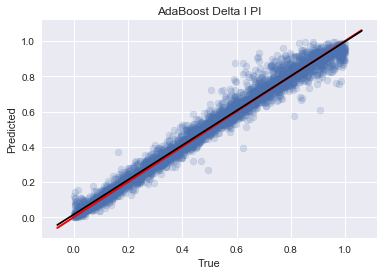

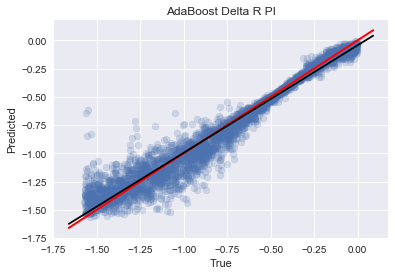

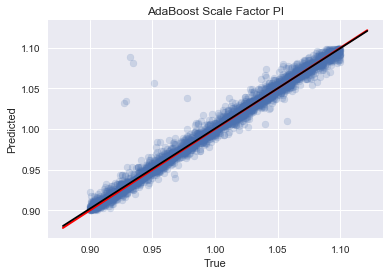

In [35]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB_di_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_AB_dr_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
regr_AB_sf_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

model_AB_di_pi = regr_AB_di_pi.fit(X2_train, Y2_train['deltaI'])
model_AB_dr_pi = regr_AB_dr_pi.fit(X2_train, Y2_train['deltaR'])
model_AB_sf_pi = regr_AB_sf_pi.fit(X2_train, Y2_train['scale factor'])

predictions_AB_di_pi = model_AB_di_pi.predict(X2_test)
predictions_AB_dr_pi = model_AB_dr_pi.predict(X2_test)
predictions_AB_sf_pi = model_AB_sf_pi.predict(X2_test)

plotSummary(Y2_test['deltaI'], predictions_AB_di_pi, 'AdaBoost Delta I PI')
plotSummary(Y2_test['deltaR'], predictions_AB_dr_pi, 'AdaBoost Delta R PI')
plotSummary(Y2_test['scale factor'], predictions_AB_sf_pi, 'AdaBoost Scale Factor PI')

In [36]:
# peak info adaboost random forest feature importances delta R  
FI_pi_AB_dr = pd.DataFrame(model_AB_dr_pi.feature_importances_.T, columns = ['Peak - AB_dr'])
FI_pi_AB_dr.index = X2_train.columns

# print(FI_pi_AB_dr[FI_pi_AB_dr['Peak - AB_dr']>0.001])
features_pi_AB_dr = (FI_pi_AB_dr[FI_pi_AB_dr['Peak - AB_dr']>0.006])
features_pi_AB_dr_sorted = features_pi_AB_dr.sort_values('Peak - AB_dr', ascending = False)


# peak info adaboost random forest feature importances delta I 
FI_pi_AB_di = pd.DataFrame(model_AB_di_pi.feature_importances_.T, columns = ['Peak - AB_di'])
FI_pi_AB_di.index = X2_train.columns

# print(FI_pi_AB_di[FI_pi_AB_di['Peak - AB_di']>0.001])
features_pi_AB_di = (FI_pi_AB_di[FI_pi_AB_di['Peak - AB_di']>0.006])
features_pi_AB_di_sorted = features_pi_AB_di.sort_values('Peak - AB_di', ascending = False)

# peak info adaboost random forest feature importances scale factor
FI_pi_AB_sf = pd.DataFrame(model_AB_sf_pi.feature_importances_.T, columns = ['Peak - AB_sf'])
FI_pi_AB_sf.index = X2_train.columns

# print(FI_pi_AB_sf[FI_pi_AB_sf['Peak - AB_sf']>0.001])
features_pi_AB_sf = (FI_pi_AB_sf[FI_pi_AB_sf['Peak - AB_sf']>0.006])
features_pi_AB_sf_sorted = features_pi_AB_sf.sort_values('Peak - AB_sf', ascending = False)


### spec points and peak info

 
RMSE on test data: 0.06231181917390209 for  AdaBoost Delta I Combo
R^2 Score on test data: 0.9524501900667958 for AdaBoost Delta I Combo
 
RMSE on test data: 0.12907025171002537 for  AdaBoost Delta R Combo
R^2 Score on test data: 0.919453864326591 for AdaBoost Delta R Combo
 
RMSE on test data: 0.004773812862013552 for  AdaBoost Scale Factor Combo
R^2 Score on test data: 0.9931784956833818 for AdaBoost Scale Factor Combo


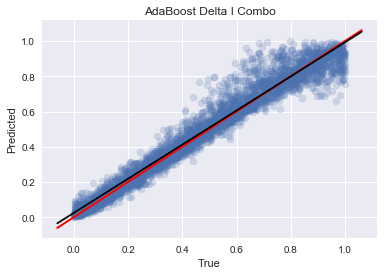

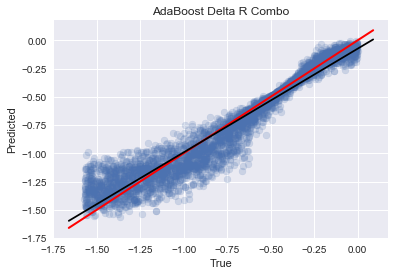

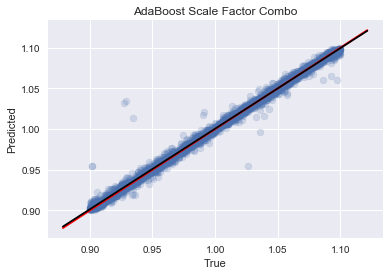

In [37]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB_di_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_AB_dr_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
regr_AB_sf_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

model_AB_di_both = regr_AB_di_both.fit(X_train, Y_train['deltaI'])
model_AB_dr_both = regr_AB_dr_both.fit(X_train, Y_train['deltaR'])
model_AB_sf_both = regr_AB_sf_both.fit(X_train, Y_train['scale factor'])

predictions_AB_di_both = model_AB_di_both.predict(X_test)
predictions_AB_dr_both = model_AB_dr_both.predict(X_test)
predictions_AB_sf_both = model_AB_sf_both.predict(X_test)

plotSummary(Y_test['deltaI'], predictions_AB_di_both, 'AdaBoost Delta I Combo')
plotSummary(Y_test['deltaR'], predictions_AB_dr_both, 'AdaBoost Delta R Combo')
plotSummary(Y_test['scale factor'], predictions_AB_sf_both, 'AdaBoost Scale Factor Combo')

In [38]:
# combined info adaboost random forest feature importances delta R  
FI_b_AB_dr = pd.DataFrame(model_AB_dr_both.feature_importances_.T, columns = ['Both - AB_dr'])
FI_b_AB_dr.index = X_train.columns

# print(FI_b_AB_dr[FI_b_AB_dr['Both - AB_dr']>0.001])
features_b_AB_dr = (FI_b_AB_dr[FI_b_AB_dr['Both - AB_dr']>0.006])
features_b_AB_dr_sorted = features_b_AB_dr.sort_values('Both - AB_dr', ascending = False)


# combined info adaboost random forest feature importances delta I  
FI_b_AB_di = pd.DataFrame(model_AB_di_both.feature_importances_.T, columns = ['Both - AB_di'])
FI_b_AB_di.index = X_train.columns

# print(FI_b_AB_di[FI_b_AB_di['Both - AB_di']>0.001])
features_b_AB_di = (FI_b_AB_di[FI_b_AB_di['Both - AB_di']>0.006])
features_b_AB_di_sorted = features_b_AB_di.sort_values('Both - AB_di', ascending = False)

# combined info adaboost random forest feature importances scale factor 
FI_b_AB_sf = pd.DataFrame(model_AB_sf_both.feature_importances_.T, columns = ['Both - AB_sf'])
FI_b_AB_sf.index = X_train.columns

# print(FI_b_AB_sf[FI_b_AB_sf['Both - AB_sf']>0.001])
features_b_AB_sf = (FI_b_AB_sf[FI_b_AB_sf['Both - AB_sf']>0.006])
features_b_AB_sf_sorted = features_b_AB_sf.sort_values('Both - AB_sf', ascending = False)

In [39]:
display_side_by_side(features_sp_AB_dr_sorted, features_sp_AB_di_sorted, features_sp_AB_sf_sorted, features_b_AB_dr_sorted, features_b_AB_di_sorted, features_b_AB_sf_sorted)
display_side_by_side(features_pi_AB_dr_sorted, features_pi_AB_di_sorted, features_pi_AB_sf_sorted)

,Spec - AB_dr
E_-290_mV,0.159272
E_-292_mV,0.151800
E_-216_mV,0.030400
E_-214_mV,0.020613
E_-218_mV,0.019904
E_-34_mV,0.013012
E_-300_mV,0.012781
E_-38_mV,0.011799
E_-286_mV,0.011609
E_-284_mV,0.011301


,Peak - AB_dr
peak4,0.587650
prom4,0.101620
prom3,0.060375
peak2,0.043482
peak3,0.039894
width2,0.038335
prom2,0.037897
width4,0.031712
width3,0.022230
loc2,0.021381


## Gradient Boosting Random Forest

### spec points

 
RMSE on test data: 0.10756927375742889 for  GradientBoost Delta I SP
R^2 Score on test data: 0.8582952535515473 for GradientBoost Delta I SP
 
RMSE on test data: 0.19069740325723739 for  GradientBoost Delta R SP
R^2 Score on test data: 0.8241744624684211 for GradientBoost Delta R SP
 
RMSE on test data: 0.006586543447220882 for  GradientBoost Scale Factor SP
R^2 Score on test data: 0.9870143258874141 for GradientBoost Scale Factor SP


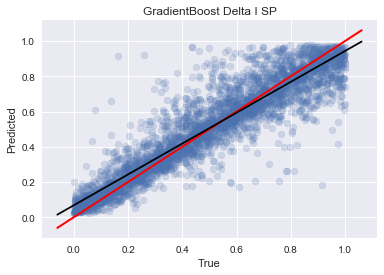

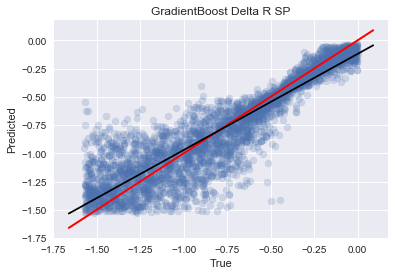

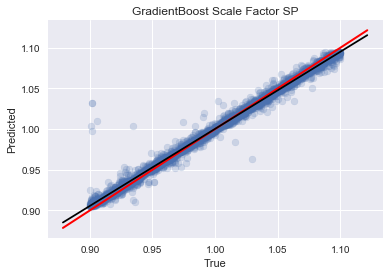

In [40]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

regr_GB_di_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_dr_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_sf_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

model_GB_di_sp = regr_GB_di_sp.fit(X1_train, Y1_train['deltaI'])
model_GB_dr_sp = regr_GB_dr_sp.fit(X1_train, Y1_train['deltaR'])
model_GB_sf_sp = regr_GB_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_GB_di_sp = model_GB_di_sp.predict(X1_test)
predictions_GB_dr_sp = model_GB_dr_sp.predict(X1_test)
predictions_GB_sf_sp = model_GB_sf_sp.predict(X1_test)

plotSummary(Y1_test['deltaI'], predictions_GB_di_sp, 'GradientBoost Delta I SP')
plotSummary(Y1_test['deltaR'], predictions_GB_dr_sp, 'GradientBoost Delta R SP')
plotSummary(Y1_test['scale factor'], predictions_GB_sf_sp, 'GradientBoost Scale Factor SP')

In [41]:
# spec info gradientboost random forest feature importances delta R  
FI_sp_GB_dr = pd.DataFrame(model_GB_dr_sp.feature_importances_.T, columns = ['Spec - GB_dr'])
FI_sp_GB_dr.index = X1_train.columns

# print(FI_sp_GB_dr[FI_sp_GB_dr['Spec - GB_dr']>0.001])
features_sp_GB_dr = (FI_sp_GB_dr[FI_sp_GB_dr['Spec - GB_dr']>0.006])
features_sp_GB_dr_sorted = features_sp_GB_dr.sort_values('Spec - GB_dr', ascending = False)

# spec info gradientboost random forest feature importances delta I  
FI_sp_GB_di = pd.DataFrame(model_GB_di_sp.feature_importances_.T, columns = ['Spec - GB_di'])
FI_sp_GB_di.index = X1_train.columns

# print(FI_sp_GB_di[FI_sp_GB_di['Spec - GB_di']>0.001])
features_sp_GB_di = (FI_sp_GB_di[FI_sp_GB_di['Spec - GB_di']>0.006])
features_sp_GB_di_sorted = features_sp_GB_di.sort_values('Spec - GB_di', ascending = False)

# spec info gradientboost random forest feature importances scale factor   
FI_sp_GB_sf = pd.DataFrame(model_GB_sf_sp.feature_importances_.T, columns = ['Spec - GB_sf'])
FI_sp_GB_sf.index = X1_train.columns

# print(FI_sp_GB_sf[FI_sp_GB_sf['Spec - GB_sf']>0.001])
features_sp_GB_sf = (FI_sp_GB_sf[FI_sp_GB_sf['Spec - GB_sf']>0.006])
features_sp_GB_sf_sorted = features_sp_GB_sf.sort_values('Spec - GB_sf', ascending = False)

### peak info

 
RMSE on test data: 0.05987112193773929 for  GradientBoost Delta I PI
R^2 Score on test data: 0.9561022038553793 for GradientBoost Delta I PI
 
RMSE on test data: 0.12351105901034143 for  GradientBoost Delta R PI
R^2 Score on test data: 0.9262428569414681 for GradientBoost Delta R PI
 
RMSE on test data: 0.007778872053968063 for  GradientBoost Scale Factor PI
R^2 Score on test data: 0.9818873233364375 for GradientBoost Scale Factor PI


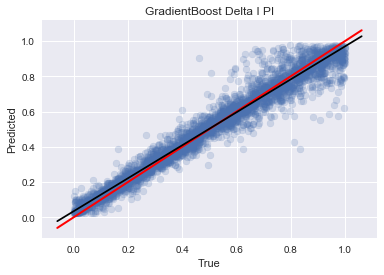

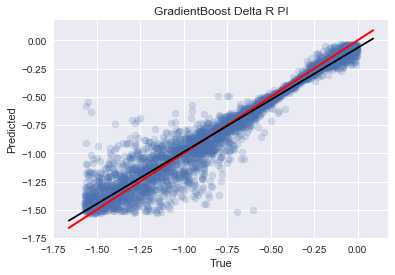

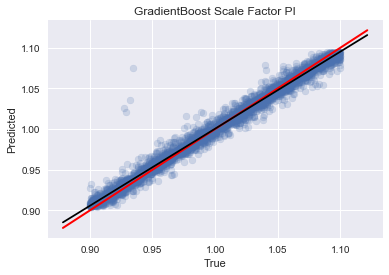

In [42]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

regr_GB_di_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_dr_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_sf_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

model_GB_di_pi = regr_GB_di_pi.fit(X2_train, Y2_train['deltaI'])
model_GB_dr_pi = regr_GB_dr_pi.fit(X2_train, Y2_train['deltaR'])
model_GB_sf_pi = regr_GB_sf_pi.fit(X2_train, Y2_train['scale factor'])

predictions_GB_di_pi = model_GB_di_pi.predict(X2_test)
predictions_GB_dr_pi = model_GB_dr_pi.predict(X2_test)
predictions_GB_sf_pi = model_GB_sf_pi.predict(X2_test)

plotSummary(Y2_test['deltaI'], predictions_GB_di_pi, 'GradientBoost Delta I PI')
plotSummary(Y2_test['deltaR'], predictions_GB_dr_pi, 'GradientBoost Delta R PI')
plotSummary(Y2_test['scale factor'], predictions_GB_sf_pi, 'GradientBoost Scale Factor PI')

In [43]:
# peak info gradient boost random forest feature importances delta R  
FI_pi_GB_dr = pd.DataFrame(model_GB_dr_pi.feature_importances_.T, columns = ['Peak - GB_dr'])
FI_pi_GB_dr.index = X2_train.columns

# print(FI_pi_GB_dr[FI_pi_AB_dr['Peak - GB_dr']>0.001])
features_pi_GB_dr = (FI_pi_GB_dr[FI_pi_GB_dr['Peak - GB_dr']>0.006])
features_pi_GB_dr_sorted = features_pi_GB_dr.sort_values('Peak - GB_dr', ascending = False)


# peak info gradientboost random forest feature importances delta I 
FI_pi_GB_di = pd.DataFrame(model_GB_di_pi.feature_importances_.T, columns = ['Peak - GB_di'])
FI_pi_GB_di.index = X2_train.columns

# print(FI_pi_GB_di[FI_pi_GB_di['Peak - GB_di']>0.001])
features_pi_GB_di = (FI_pi_GB_di[FI_pi_GB_di['Peak - GB_di']>0.006])
features_pi_GB_di_sorted = features_pi_GB_di.sort_values('Peak - GB_di', ascending = False)


# peak info gradientboost random forest feature importances scale factor
FI_pi_GB_sf = pd.DataFrame(model_GB_sf_pi.feature_importances_.T, columns = ['Peak - GB_sf'])
FI_pi_GB_sf.index = X2_train.columns

# print(FI_pi_GB_sf[FI_pi_GB_sf['Peak - GB_sf']>0.001])
features_pi_GB_sf = (FI_pi_GB_sf[FI_pi_GB_sf['Peak - GB_sf']>0.006])
features_pi_GB_sf_sorted = features_pi_GB_sf.sort_values('Peak - GB_sf', ascending = False)

### spec points and peak info

 
RMSE on test data: 0.07628636863196782 for  GradientBoost Delta I Combo
R^2 Score on test data: 0.9287308123437469 for GradientBoost Delta I Combo
 
RMSE on test data: 0.16410369947903142 for  GradientBoost Delta R Combo
R^2 Score on test data: 0.8697945572433826 for GradientBoost Delta R Combo
 
RMSE on test data: 0.006856589125992902 for  GradientBoost Scale Factor Combo
R^2 Score on test data: 0.985927682374895 for GradientBoost Scale Factor Combo


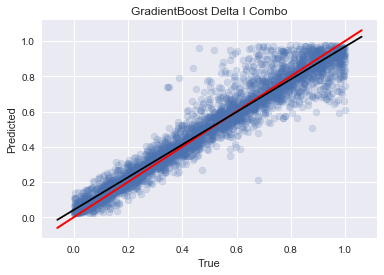

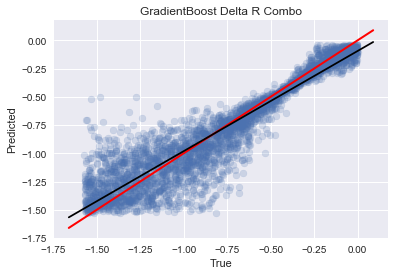

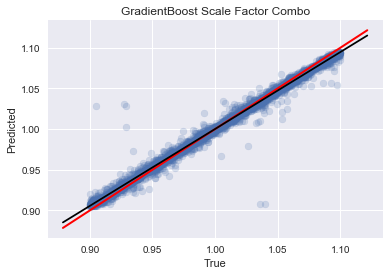

In [44]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

regr_GB_di_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_dr_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_sf_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

model_GB_di_both = regr_GB_di_both.fit(X_train, Y_train['deltaI'])
model_GB_dr_both = regr_GB_dr_both.fit(X_train, Y_train['deltaR'])
model_GB_sf_both = regr_GB_sf_both.fit(X_train, Y_train['scale factor'])

predictions_GB_di_both = model_GB_di_both.predict(X_test)
predictions_GB_dr_both = model_GB_dr_both.predict(X_test)
predictions_GB_sf_both = model_GB_sf_both.predict(X_test)

plotSummary(Y_test['deltaI'], predictions_GB_di_both, 'GradientBoost Delta I Combo')
plotSummary(Y_test['deltaR'], predictions_GB_dr_both, 'GradientBoost Delta R Combo')
plotSummary(Y_test['scale factor'], predictions_GB_sf_both, 'GradientBoost Scale Factor Combo')


In [45]:
# combined info gradient boost random forest feature importances delta R  
FI_b_GB_dr = pd.DataFrame(model_GB_dr_both.feature_importances_.T, columns = ['Both - GB_dr'])
FI_b_GB_dr.index = X_train.columns

# print(FI_b_GB_dr[FI_b_GB_dr['Both - GB_dr']>0.001])
features_b_GB_dr = (FI_b_GB_dr[FI_b_GB_dr['Both - GB_dr']>0.006])
features_b_GB_dr_sorted = features_b_GB_dr.sort_values('Both - GB_dr', ascending = False)


# combined info gradient boost random forest feature importances delta I  
FI_b_GB_di = pd.DataFrame(model_GB_di_both.feature_importances_.T, columns = ['Both - GB_di'])
FI_b_GB_di.index = X_train.columns

# print(FI_b_GB_di[FI_b_GB_di['Both - GB_di']>0.001])
features_b_GB_di = (FI_b_GB_di[FI_b_GB_di['Both - GB_di']>0.006])
features_b_GB_di_sorted = features_b_GB_di.sort_values('Both - GB_di', ascending = False)

# combined info gradient boost random forest feature importances scale factor 
FI_b_GB_sf = pd.DataFrame(model_GB_sf_both.feature_importances_.T, columns = ['Both - GB_sf'])
FI_b_GB_sf.index = X_train.columns

# print(FI_b_GB_sf[FI_b_GB_sf['Both - GB_sf']>0.001])
features_b_GB_sf = (FI_b_GB_sf[FI_b_GB_sf['Both - GB_sf']>0.006])
features_b_GB_sf_sorted = features_b_GB_sf.sort_values('Both - GB_sf', ascending = False)

In [46]:
display_side_by_side(features_sp_GB_dr_sorted, features_sp_GB_di_sorted,features_sp_GB_sf_sorted, features_b_GB_dr_sorted, features_b_GB_di_sorted, features_b_GB_sf_sorted)
display_side_by_side(features_pi_GB_dr_sorted, features_pi_GB_di_sorted, features_pi_GB_sf_sorted)

,Spec - GB_dr
E_-292_mV,0.443964
E_-218_mV,0.092027
E_-288_mV,0.054383
E_-36_mV,0.053798
E_-300_mV,0.016616
E_-44_mV,0.012175
E_-122_mV,0.010830
E_-296_mV,0.008569
E_230_mV,0.007254
E_64_mV,0.007066


,Peak - GB_dr
peak4,0.732067
prom3,0.084812
peak2,0.035174
prom4,0.030397
width2,0.027480
width4,0.021084
prom2,0.019987
peak3,0.017778
width3,0.014651
loc2,0.012959


In [47]:
display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_dr_sorted,features_sp_AB_dr_sorted,features_sp_RF2_dr_sorted)

,Spec - RF
E_-290_mV,0.269235
E_-292_mV,0.169715
E_-288_mV,0.039141
E_-216_mV,0.038302
E_-294_mV,0.024365
E_-40_mV,0.017072
E_-296_mV,0.016925
E_-214_mV,0.016682
E_-44_mV,0.016419
E_-42_mV,0.012699


In [48]:
display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_di_sorted,features_sp_AB_di_sorted,features_sp_RF2_di_sorted)

,Spec - RF
E_-290_mV,0.269235
E_-292_mV,0.169715
E_-288_mV,0.039141
E_-216_mV,0.038302
E_-294_mV,0.024365
E_-40_mV,0.017072
E_-296_mV,0.016925
E_-214_mV,0.016682
E_-44_mV,0.016419
E_-42_mV,0.012699


In [49]:
display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_sf_sorted,features_sp_AB_sf_sorted,features_sp_RF2_sf_sorted)

,Spec - RF
E_-290_mV,0.269235
E_-292_mV,0.169715
E_-288_mV,0.039141
E_-216_mV,0.038302
E_-294_mV,0.024365
E_-40_mV,0.017072
E_-296_mV,0.016925
E_-214_mV,0.016682
E_-44_mV,0.016419
E_-42_mV,0.012699


In [50]:
display_side_by_side(features_pi_RF_sorted, features_pi_DT_sorted, features_pi_GB_dr_sorted,features_pi_AB_dr_sorted,features_pi_RF2_dr_sorted)

,Peak - RF
peak4,0.622156
peak2,0.192364
prom4,0.053880
width2,0.033183
prom2,0.027499
prom3,0.024502
peak3,0.016394
width3,0.009465
width4,0.009376
,Peak - DT


In [51]:
display_side_by_side(features_pi_RF_sorted, features_pi_DT_sorted, features_pi_GB_di_sorted,features_pi_AB_di_sorted,features_pi_RF2_di_sorted)

,Peak - RF
peak4,0.622156
peak2,0.192364
prom4,0.053880
width2,0.033183
prom2,0.027499
prom3,0.024502
peak3,0.016394
width3,0.009465
width4,0.009376
,Peak - DT


In [52]:
display_side_by_side(features_pi_RF_sorted, features_pi_DT_sorted, features_pi_GB_sf_sorted,features_pi_AB_sf_sorted,features_pi_RF2_sf_sorted)

,Peak - RF
peak4,0.622156
peak2,0.192364
prom4,0.053880
width2,0.033183
prom2,0.027499
prom3,0.024502
peak3,0.016394
width3,0.009465
width4,0.009376
,Peak - DT


In [53]:
display_side_by_side(features_b_RF_sorted, features_b_DT_sorted, features_b_GB_dr_sorted,features_b_AB_dr_sorted,features_b_RF2_dr_sorted)

,Both - RF
peak4,0.613134
peak2,0.190763
prom4,0.040377
width2,0.023155
prom2,0.017824
prom3,0.016735
peak3,0.008898
,Both - DT
peak4,0.629153
peak2,0.201514


In [54]:
display_side_by_side(features_b_RF_sorted, features_b_DT_sorted, features_b_GB_di_sorted,features_b_AB_di_sorted,features_b_RF2_di_sorted)

,Both - RF
peak4,0.613134
peak2,0.190763
prom4,0.040377
width2,0.023155
prom2,0.017824
prom3,0.016735
peak3,0.008898
,Both - DT
peak4,0.629153
peak2,0.201514


In [55]:
display_side_by_side(features_b_RF_sorted, features_b_DT_sorted, features_b_GB_sf_sorted,features_b_AB_sf_sorted,features_b_RF2_sf_sorted)

,Both - RF
peak4,0.613134
peak2,0.190763
prom4,0.040377
width2,0.023155
prom2,0.017824
prom3,0.016735
peak3,0.008898
,Both - DT
peak4,0.629153
peak2,0.201514


## Testing the Models on the Experimental Data



In [56]:
# Load the experimental data
col_names3 = peak_names + locs_names + width_names + prom_names
col_names4 = energy_names
col_names_exp_both = col_names_both[2:]

exp_data_sp = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData180721_PS_sf_specPoints.csv', header = None, names = col_names4)
exp_data_pi = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData180721_PS_sf_peakinfo.csv', header = None, names = col_names3)

In [57]:
energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]
col_names1a = energy_names[50:] # use for taking out first peak specs 
exp_data_sp = exp_data_sp[col_names1a] # use for taking out first peak specs 
exp_data_sp

,E_-300_mV,E_-298_mV,E_-296_mV,E_-294_mV,E_-292_mV,E_-290_mV,E_-288_mV,E_-286_mV,E_-284_mV,E_-282_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.63866,0.64322,0.6455,0.6487,0.65752,0.66493,0.67365,0.68098,0.69691,0.70971,...,1.0453,1.0284,0.99538,0.98221,0.97146,0.97284,0.98729,0.98385,0.98191,0.97779


In [58]:
## Use these if want to remove first peak info
peak_names2 = ['peak2', 'peak3', 'peak4']
prom_names2 = ['prom2', 'prom3', 'prom4']
locs_names2 = ['loc2', 'loc3', 'loc4']
width_names2 = ['width2', 'width3', 'width4']
pi_names = peak_names2 + locs_names2 + width_names2 + prom_names2
exp_data_pi = exp_data_pi[pi_names]
exp_data_pi

,peak2,peak3,peak4,loc2,loc3,loc4,width2,width3,width4,prom2,prom3,prom4
0,1.9262,1.8662,1.4495,-0.242,-0.074,0.134,0.032045,0.039422,0.04612,1.2902,1.1855,0.57098


In [59]:
# Use these if want to remove first peak info 
#subset = 5 
energy_names2 = energy_names[50:]
exp_data_sp2 = exp_data_sp[energy_names2]
exp_data_both = exp_data_pi.join(exp_data_sp2, how = 'left')
exp_data_both = exp_data_pi.join(exp_data_sp, how = 'left')
exp_data_both


,peak2,peak3,peak4,loc2,loc3,loc4,width2,width3,width4,prom2,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,1.9262,1.8662,1.4495,-0.242,-0.074,0.134,0.032045,0.039422,0.04612,1.2902,...,1.0453,1.0284,0.99538,0.98221,0.97146,0.97284,0.98729,0.98385,0.98191,0.97779


In [60]:
pred_phase_DT_sp = np.append(regr_DT_sp.predict(exp_data_sp),
                             r2_score(Y1_test['deltaI'], predictions_DT_sp[:,0])).reshape(4,1).T
pred_phase_DT_sp = np.append(pred_phase_DT_sp, 
                             r2_score(Y1_test['deltaR'], predictions_DT_sp[:,1])).reshape(5,1).T
pred_phase_DT_sp = np.append(pred_phase_DT_sp, 
                             r2_score(Y1_test['scale factor'], predictions_DT_sp[:,2])).reshape(6,1).T

pred_phase_DT_pi = np.append(regr_DT_pi.predict(exp_data_pi), 
                            r2_score(Y1_test['deltaI'], predictions_DT_pi[:,0])).reshape(4,1).T
pred_phase_DT_pi = np.append(pred_phase_DT_pi, 
                            r2_score(Y1_test['deltaR'], predictions_DT_pi[:,1])).reshape(5,1).T
pred_phase_DT_pi = np.append(pred_phase_DT_pi, 
                            r2_score(Y1_test['scale factor'], predictions_DT_pi[:,2])).reshape(6,1).T

pred_phase_DT_both = np.append(regr_DT_both.predict(exp_data_both), 
                            r2_score(Y_test['deltaI'], predictions_DT_both[:,0])).reshape(4,1).T
pred_phase_DT_both = np.append(pred_phase_DT_both, 
                            r2_score(Y_test['deltaR'], predictions_DT_both[:,1])).reshape(5,1).T
pred_phase_DT_both = np.append(pred_phase_DT_both, 
                            r2_score(Y_test['scale factor'], predictions_DT_both[:,2])).reshape(6,1).T

In [61]:
pred_phase_RF_sp = regr_RF_sp.predict(exp_data_sp)
pred_phase_RF_pi = regr_RF_pi.predict(exp_data_pi)
pred_phase_RF_both = regr_RF_both.predict(exp_data_both)

pred_phase_AB_R_sp = model_AB_dr_sp.predict(exp_data_sp)
pred_phase_AB_I_sp = model_AB_di_sp.predict(exp_data_sp)
pred_phase_AB_sf_sp = model_AB_sf_sp.predict(exp_data_sp)

pred_phase_AB_R_pi = model_AB_dr_pi.predict(exp_data_pi)
pred_phase_AB_I_pi = model_AB_di_pi.predict(exp_data_pi)
pred_phase_AB_sf_pi = model_AB_sf_pi.predict(exp_data_pi)

pred_phase_AB_R_both = model_AB_dr_both.predict(exp_data_both)
pred_phase_AB_I_both = model_AB_di_both.predict(exp_data_both)
pred_phase_AB_sf_both = model_AB_sf_both.predict(exp_data_both)

pred_phase_GB_di_sp = model_GB_di_sp.predict(exp_data_sp)
pred_phase_GB_dr_sp = model_GB_dr_sp.predict(exp_data_sp)
pred_phase_GB_sf_sp = model_GB_sf_sp.predict(exp_data_sp)

pred_phase_GB_di_pi = model_GB_di_pi.predict(exp_data_pi)
pred_phase_GB_dr_pi = model_GB_dr_pi.predict(exp_data_pi)
pred_phase_GB_sf_pi = model_GB_sf_pi.predict(exp_data_pi)

pred_phase_GB_di_both = model_GB_di_both.predict(exp_data_both)
pred_phase_GB_dr_both = model_GB_dr_both.predict(exp_data_both)
pred_phase_GB_sf_both = model_GB_sf_both.predict(exp_data_both)

pred_phase_IRF_di_sp = model_RF2_di_sp.predict(exp_data_sp)
pred_phase_IRF_dr_sp = model_RF2_dr_sp.predict(exp_data_sp)
pred_phase_IRF_sf_sp = model_RF2_sf_sp.predict(exp_data_sp)

pred_phase_IRF_di_pi = model_RF2_di_pi.predict(exp_data_pi)
pred_phase_IRF_dr_pi = model_RF2_dr_pi.predict(exp_data_pi)
pred_phase_IRF_sf_pi = model_RF2_sf_pi.predict(exp_data_pi)

pred_phase_IRF_di_both = model_RF2_di_both.predict(exp_data_both)
pred_phase_IRF_dr_both = model_RF2_dr_both.predict(exp_data_both)
pred_phase_IRF_sf_both = model_RF2_sf_both.predict(exp_data_both)


In [83]:
predictedPhases = pd.DataFrame(pred_phase_DT_sp, columns = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score', 'scale factor', 'scale factor score'], index = ['Decision Tree spec points'])


In [84]:
new_test = pd.Series(pred_phase_DT_pi[0], index = ['deltaI', 'deltaR', 'scale factor', 'deltaI score', 'deltaR score', 'scale factor score'], name = 'Decision Tree peak info')
predictedPhases = predictedPhases.append(new_test)

In [85]:
new_1 = pd.Series(pred_phase_DT_both[0], index = ['deltaI', 'deltaR', 'scale factor', 'deltaI score', 'deltaR score', 'scale factor score'], name = 'Decision Tree spec points and peak info')
predictedPhases = predictedPhases.append(new_1)

In [86]:
RF_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF_sp[:,0])
RF_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF_sp[:,1])
RF_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF_sp[:,2])

RF_pi_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF_pi[:,0])
RF_pi_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF_pi[:,1])
RF_pi_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF_pi[:,2])

RF_b_di_r2score = r2_score(Y_test['deltaI'], predictions_RF_both[:,0])
RF_b_dr_r2score = r2_score(Y_test['deltaR'], predictions_RF_both[:,1])
RF_b_sf_r2score = r2_score(Y_test['scale factor'], predictions_RF_both[:,2])

In [87]:
predictedPhases.loc['Random Forest spec points'] = (pred_phase_RF_sp[0,0], pred_phase_RF_sp[0,1], pred_phase_RF_sp[0,2], RF_sp_di_r2score, RF_sp_dr_r2score, RF_sp_sf_r2score)
predictedPhases.loc['Random Forest peak info'] = (pred_phase_RF_pi[0,0], pred_phase_RF_pi[0,1], pred_phase_RF_pi[0,2], RF_pi_di_r2score, RF_pi_dr_r2score, RF_pi_sf_r2score )
predictedPhases.loc['Random Forest spec points and peak info'] = (pred_phase_RF_both[0,0], pred_phase_RF_both[0,1], pred_phase_RF_both[0,2], RF_b_di_r2score, RF_b_dr_r2score, RF_b_sf_r2score)

In [88]:
AB_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_AB_di_sp)
AB_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_AB_dr_sp)
AB_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_AB_sf_sp)

AB_pi_di_r2score = r2_score(Y1_test['deltaI'], predictions_AB_di_pi)
AB_pi_dr_r2score = r2_score(Y1_test['deltaR'], predictions_AB_dr_pi)
AB_pi_sf_r2score = r2_score(Y1_test['scale factor'], predictions_AB_sf_pi)

AB_b_di_r2score = r2_score(Y1_test['deltaI'], predictions_AB_di_both)
AB_b_dr_r2score = r2_score(Y1_test['deltaR'], predictions_AB_dr_both)
AB_b_sf_r2score = r2_score(Y1_test['scale factor'], predictions_AB_sf_both)

In [89]:
predictedPhases.loc['AdaBoost spec points'] = (pred_phase_AB_I_sp[0], pred_phase_AB_R_sp[0], pred_phase_AB_sf_sp[0], AB_sp_di_r2score, AB_sp_dr_r2score, AB_sp_sf_r2score)
predictedPhases.loc['AdaBoost peak info'] = (pred_phase_AB_I_pi[0], pred_phase_AB_R_pi[0], pred_phase_AB_sf_pi[0], AB_pi_di_r2score, AB_pi_dr_r2score, AB_pi_sf_r2score) 
predictedPhases.loc['AdaBoost spec points and peak info'] = (pred_phase_AB_I_both[0], pred_phase_AB_R_both[0], pred_phase_AB_sf_both[0], AB_b_di_r2score, AB_b_dr_r2score, AB_b_sf_r2score)


In [90]:
GB_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_GB_di_sp)
GB_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_GB_dr_sp)
GB_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_GB_sf_sp)

GB_pi_di_r2score = r2_score(Y1_test['deltaI'], predictions_GB_di_pi)
GB_pi_dr_r2score = r2_score(Y1_test['deltaR'], predictions_GB_dr_pi)
GB_pi_sf_r2score = r2_score(Y1_test['scale factor'], predictions_GB_sf_pi)

GB_b_di_r2score = r2_score(Y1_test['deltaI'], predictions_GB_di_both)
GB_b_dr_r2score = r2_score(Y1_test['deltaR'], predictions_GB_dr_both)
GB_b_sf_r2score = r2_score(Y1_test['scale factor'], predictions_GB_sf_both)

In [91]:
predictedPhases.loc['Gradient Boosting spec points'] = (pred_phase_GB_di_sp[0], pred_phase_GB_dr_sp[0], pred_phase_GB_sf_sp[0], GB_sp_di_r2score, GB_sp_dr_r2score, GB_sp_sf_r2score)
predictedPhases.loc['Gradient Boosting peak info'] = (pred_phase_GB_di_pi[0], pred_phase_GB_dr_pi[0], pred_phase_GB_sf_pi[0], GB_pi_di_r2score, GB_pi_dr_r2score, GB_pi_sf_r2score) 
predictedPhases.loc['Gradient Boosting spec points and peak info'] = (pred_phase_GB_di_both[0], pred_phase_GB_dr_both[0], pred_phase_GB_sf_both[0], GB_b_di_r2score, GB_b_dr_r2score, GB_b_sf_r2score)


In [92]:
IRF_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF2_di_sp)
IRF_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF2_dr_sp)
IRF_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF2_sf_sp)

IRF_pi_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF2_di_pi)
IRF_pi_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF2_dr_pi)
IRF_pi_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF2_sf_pi)

IRF_b_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF2_di_both)
IRF_b_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF2_dr_both)
IRF_b_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF2_sf_both)

In [93]:
predictedPhases.loc['Independent Random Forests spec points'] = (pred_phase_IRF_di_sp[0], pred_phase_IRF_dr_sp[0],  pred_phase_IRF_sf_sp[0], IRF_sp_di_r2score, IRF_sp_dr_r2score, IRF_sp_sf_r2score)
predictedPhases.loc['Independent Random Forests peak info'] = (pred_phase_IRF_di_pi[0], pred_phase_IRF_dr_pi[0],  pred_phase_IRF_sf_pi[0], IRF_pi_di_r2score, IRF_pi_dr_r2score, IRF_pi_sf_r2score)
predictedPhases.loc['Independent Random Forests spec points and peak info'] = (pred_phase_IRF_di_both[0], pred_phase_IRF_dr_both[0],  pred_phase_IRF_sf_both[0], IRF_b_di_r2score, IRF_b_dr_r2score, IRF_b_sf_r2score)

In [98]:
predictedPhases

,deltaI,deltaR,deltaI score,deltaR score,scale factor,scale factor score
Decision Tree spec points,0.082010,-0.118525,1.007000,0.784639,0.796013,0.921573
Decision Tree peak info,0.315773,-0.007842,0.950440,0.919619,1.066233,0.761089
Decision Tree spec points and peak info,0.315855,-0.007064,0.918628,0.892112,1.050950,0.683427
Random Forest spec points,0.101265,-0.069920,1.019273,0.891774,0.892214,0.985831
Random Forest peak info,0.253802,-0.081778,1.035536,0.974614,0.955819,0.949321
Random Forest spec points and peak info,0.221808,-0.094855,1.016109,0.961615,0.939161,0.942754
AdaBoost spec points,0.167970,-0.032380,1.020100,0.912658,0.902769,0.993817
AdaBoost peak info,0.274100,-0.022773,1.018100,0.975275,0.948770,0.982719
AdaBoost spec points and peak info,0.237670,-0.079471,1.011200,0.952450,0.919454,0.993178
Gradient Boosting spec points,0.051272,-0.041813,1.015602,0.858295,0.824174,0.987014


In [97]:
# Predictions with 0.95 or lower scores excluded 
GoodPredictedDeltaI = predictedPhases.drop(['Decision Tree spec points and peak info', 'Decision Tree peak info'], axis = 0)
GoodPredictedDeltaR = predictedPhases.drop(['Decision Tree spec points', 'Decision Tree peak info', 'Decision Tree spec points and peak info', 'Random Forest spec points', 'AdaBoost spec points', 'Gradient Boosting spec points', 'Gradient Boosting spec points and peak info', 'Independent Random Forests spec points'], axis = 0)
GoodPredictedScaleFactor = predictedPhases.drop(['Decision Tree peak info', 'Decision Tree spec points', 'Decision Tree spec points and peak info', 'Random Forest peak info', 'Random Forest spec points and peak info'], axis = 0)


deltaI_1 = (GoodPredictedDeltaI['deltaI']*GoodPredictedDeltaI['deltaI score']).mean()
deltaR_1 = (GoodPredictedDeltaR['deltaR']*GoodPredictedDeltaR['deltaR score']).mean()
scale_factor1 = (GoodPredictedScaleFactor['scale factor']*GoodPredictedScaleFactor['scale factor score']).mean()
print('The weighted average for the predicted phase is: ', deltaR_1, ' + ', deltaI_1, '*i')
print('The weighted average for the scale factor is:', scale_factor1)

The weighted average for the predicted phase is:  -0.05790756940568192  +  0.2010938616362285 *i
The weighted average for the scale factor is: 0.8953053315327569


In [82]:
predictedPhases[['deltaI', 'deltaR', 'scale factor']].to_csv('Model_Results/Hexagon/predictions_PS_sf_FI_180721.csv')
predictedPhases[['deltaI score', 'deltaR score', 'scale factor score']].to_csv('Model_Results/Hexagon/scores_PS_sf_FI_180721.csv')



In [76]:
importance_DT_ = pd.Series(regr_DT_both.feature_importances_, index = X_train.columns)
importance_DT_ = pd.Series(regr_DT_both.feature_importances_, index = X_train.columns)
importance_RF_= pd.Series(model_RF_both.feature_importances_, index = X_train.columns)
importance_IRF_r = pd.Series(model_RF2_dr_both.feature_importances_, index = X_train.columns)
importance_IRF_i = pd.Series(model_RF2_di_both.feature_importances_, index = X_train.columns)
importance_IRF_sf = pd.Series(model_RF2_sf_both.feature_importances_, index = X_train.columns)
importance_ARF_r = pd.Series(model_AB_dr_both.feature_importances_, index = X_train.columns)
importance_ARF_i = pd.Series(model_AB_di_both.feature_importances_, index = X_train.columns)
importance_ARF_sf = pd.Series(model_AB_sf_both.feature_importances_, index = X_train.columns)
importance_GRF_r = pd.Series(model_GB_dr_both.feature_importances_, index = X_train.columns)
importance_GRF_i = pd.Series(model_GB_di_both.feature_importances_, index = X_train.columns)
importance_GRF_sf = pd.Series(model_GB_sf_both.feature_importances_, index = X_train.columns)

In [77]:
#tenFeatures = linspace(0,10, 10)
DT_FI_top = importance_DT_.nlargest(10)
RF_FI_top = importance_RF_.nlargest(10)
IRF_r_FI_top = importance_IRF_r.nlargest(10)
IRF_i_FI_top = importance_IRF_i.nlargest(10)
IRF_sf_FI_top = importance_IRF_sf.nlargest(10)
ARF_r_FI_top = importance_ARF_r.nlargest(10)
ARF_i_FI_top = importance_ARF_i.nlargest(10)
ARF_sf_FI_top = importance_ARF_sf.nlargest(10)
GRF_r_FI_top = importance_GRF_r.nlargest(10)
GRF_i_FI_top = importance_GRF_i.nlargest(10)
GRF_sf_FI_top = importance_GRF_sf.nlargest(10)
tops_list = [DT_FI_top, RF_FI_top, IRF_r_FI_top,IRF_i_FI_top, ARF_r_FI_top, ARF_i_FI_top, GRF_r_FI_top, GRF_i_FI_top ]
tops = pd.concat(tops_list)
#tops.plot(kind = 'pie')
tops_count = tops.groupby(level=[0]).size()
tops_count.sort_values(axis = 0)
tops_count = tops_count.sort_values()
tops_count

E_-224_mV    1
E_-292_mV    1
E_-290_mV    1
E_-268_mV    1
loc3         1
E_-264_mV    1
E_-262_mV    2
width3       2
E_-266_mV    3
E_-300_mV    4
peak3        7
peak2        8
peak4        8
prom2        8
prom3        8
prom4        8
width2       8
width4       8
dtype: int64

In [78]:
sf_tops_list = [IRF_sf_FI_top, ARF_sf_FI_top, GRF_sf_FI_top ]
sf_tops = pd.concat(sf_tops_list)
#sf_tops.plot(kind = 'pie')
sf_tops_count = sf_tops.groupby(level=[0]).size()
sf_tops_count.sort_values(axis = 0)
sf_tops_count = sf_tops_count.sort_values()
sf_tops_count

E_350_mV     1
E_-184_mV    1
E_-210_mV    1
E_498_mV     1
E_174_mV     1
E_228_mV     1
E_438_mV     1
E_230_mV     1
E_24_mV      1
E_286_mV     1
loc3         1
E_366_mV     1
E_436_mV     1
E_414_mV     1
E_428_mV     1
E_-182_mV    2
E_410_mV     2
E_-212_mV    2
E_22_mV      3
E_434_mV     3
loc4         3
dtype: int64

Text(0,0.5,'Feature Importance')

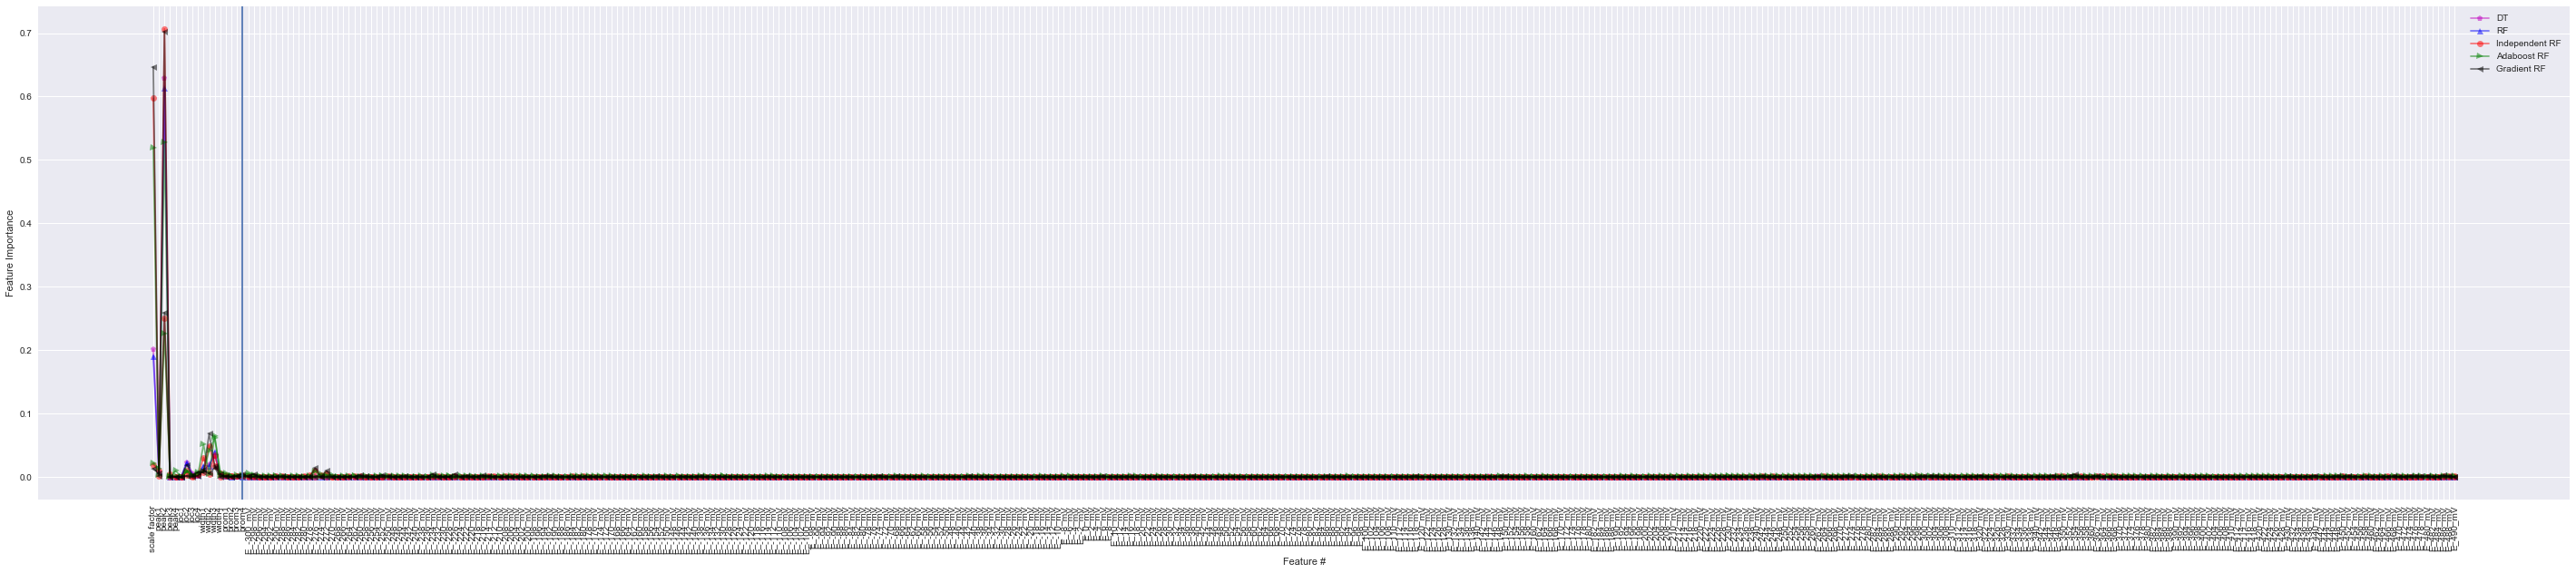

In [79]:
Features = linspace(0,413, 413)
figure(figsize=(50,10))
plt.plot(Features, importance_DT_, 'mp-', alpha = 0.5, label = "DT")
plt.plot(Features, importance_RF_, 'b^-', alpha = 0.5, label = "RF")
plt.plot(Features, importance_IRF_i,  'ro-', alpha = 0.5, label = "Independent RF")
plt.plot(Features, importance_IRF_r,  'ro-', alpha = 0.5)
plt.plot(Features, importance_ARF_i, 'g>-',alpha = 0.5, label = "Adaboost RF")
plt.plot(Features, importance_ARF_r, 'g>-',alpha = 0.5)
plt.plot(Features, importance_GRF_i, 'k<-', alpha = 0.5, label = "Gradient RF")
plt.plot(Features, importance_GRF_r, 'k<-', alpha = 0.5)
legend(loc = 'best')
plt.xticks(Features, col_names_exp_both, rotation = 'vertical')
matplotlib.pyplot.axvline(x=16, ymin=0, ymax=1)
xlabel('Feature #')
ylabel('Feature Importance')

(0, 50)

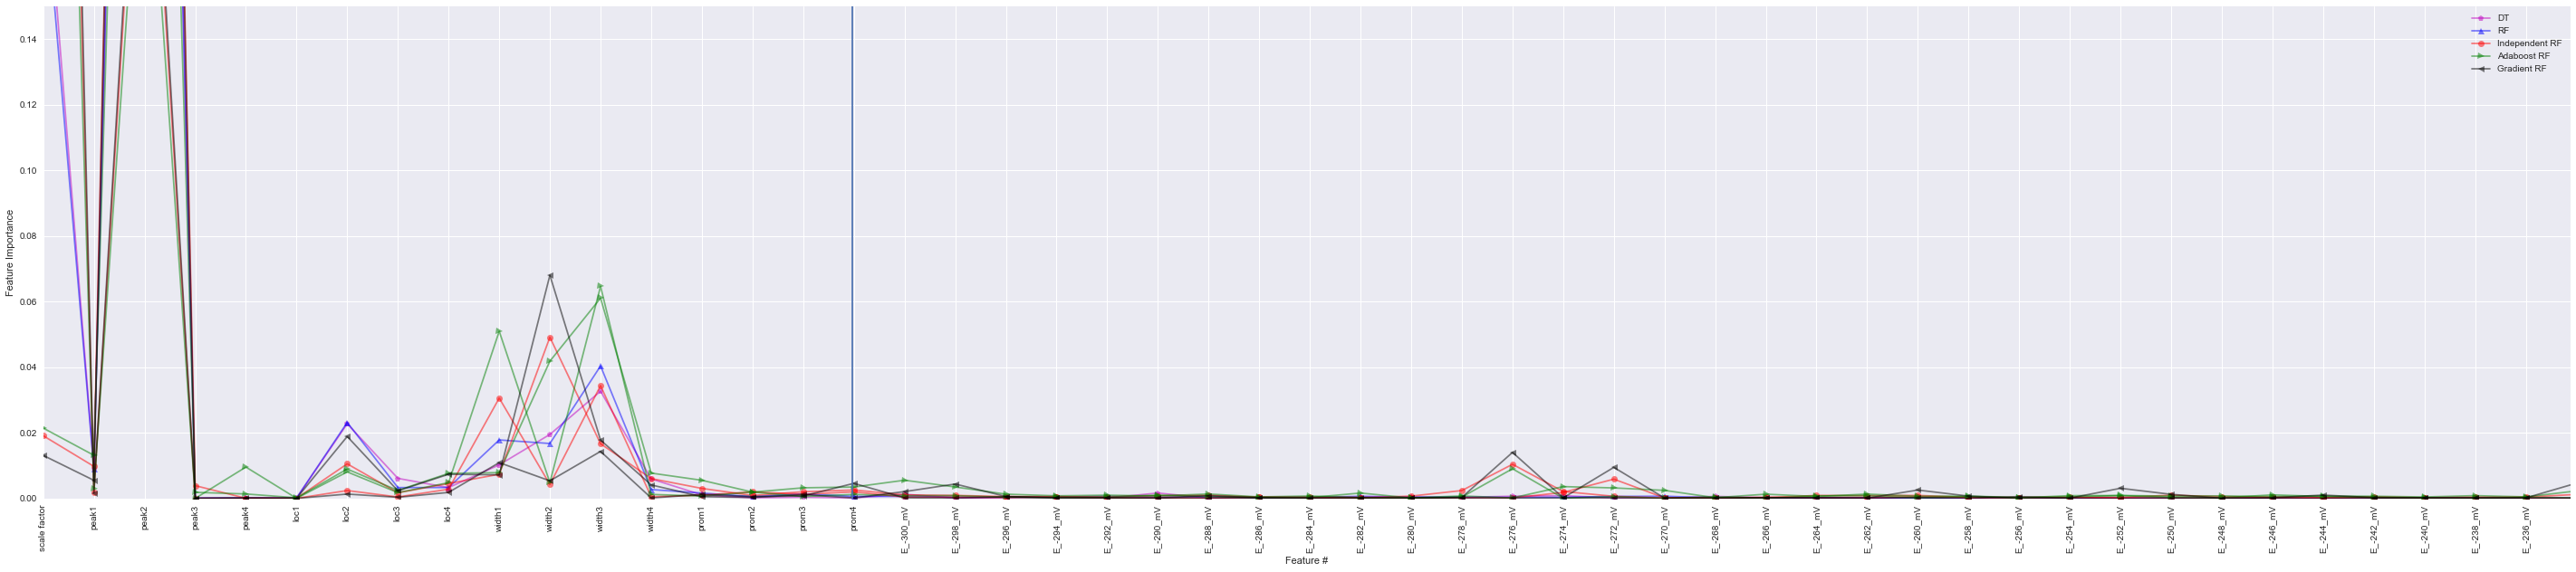

In [80]:
Features = linspace(0,413, 413)
figure(figsize=(50,10))
plt.plot(Features, importance_DT_, 'mp-', alpha = 0.5, label = "DT")
plt.plot(Features, importance_RF_, 'b^-', alpha = 0.5, label = "RF")
plt.plot(Features, importance_IRF_i,  'ro-', alpha = 0.5, label = "Independent RF")
plt.plot(Features, importance_IRF_r,  'ro-', alpha = 0.5)
plt.plot(Features, importance_ARF_i, 'g>-',alpha = 0.5, label = "Adaboost RF")
plt.plot(Features, importance_ARF_r, 'g>-',alpha = 0.5)
plt.plot(Features, importance_GRF_i, 'k<-', alpha = 0.5, label = "Gradient RF")
plt.plot(Features, importance_GRF_r, 'k<-', alpha = 0.5)
legend(loc = 'best')
plt.xticks(Features, col_names_exp_both, rotation = 'vertical')
matplotlib.pyplot.axvline(x=16, ymin=0, ymax=1)
xlabel('Feature #')
ylabel('Feature Importance')
ylim([0, 0.15])
xlim([0, 50])